In [1]:
#Import all necessary libraries
import pandas as pd
import numpy as np
import random
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from boruta import BorutaPy
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, classification_report, roc_curve, roc_auc_score
from imblearn.over_sampling import SMOTE
import shap
from tabulate import tabulate 
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn.init import kaiming_normal_
from IPython.display import clear_output

In [2]:
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

In [3]:
# Cell 2: Load and display dataset
diabetes_df = pd.read_csv('diabetes.csv')
diabetes_df

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0              6      148             72             35        0  33.6   
1              1       85             66             29        0  26.6   
2              8      183             64              0        0  23.3   
3              1       89             66             23       94  28.1   
4              0      137             40             35      168  43.1   
..           ...      ...            ...            ...      ...   ...   
763           10      101             76             48      180  32.9   
764            2      122             70             27        0  36.8   
765            5      121             72             23      112  26.2   
766            1      126             60              0        0  30.1   
767            1       93             70             31        0  30.4   

     DiabetesPedigreeFunction  Age  Outcome  
0                       0.627   50        1  
1                       0.351   31        0  
2                       0.672   32        1  
3                       0.167   21        0  
4                       2.288   33        1  
..                        ...  ...      ...  
763                     0.171   63        0  
764                     0.340   27        0  
765                     0.245   30        0  
766                     0.349   47        1  
767                     0.315   23        0  

[768 rows x 9 columns]

In [4]:
print("Dataset shape ::", diabetes_df.shape)

Dataset shape :: (768, 9)


In [5]:
print("\nClass distribution:")
print(diabetes_df['Outcome'].value_counts())


Class distribution:
0    500
1    268
Name: Outcome, dtype: int64


In [6]:
diabetes_df.describe()

Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469      20.536458   79.799479   
std       3.369578   31.972618      19.355807      15.952218  115.244002   
min       0.000000    0.000000       0.000000       0.000000    0.000000   
25%       1.000000   99.000000      62.000000       0.000000    0.000000   
50%       3.000000  117.000000      72.000000      23.000000   30.500000   
75%       6.000000  140.250000      80.000000      32.000000  127.250000   
max      17.000000  199.000000     122.000000      99.000000  846.000000   

              BMI  DiabetesPedigreeFunction         Age     Outcome  
count  768.000000                768.000000  768.000000  768.000000  
mean    31.992578                  0.471876   33.240885    0.348958  
std      7.884160                  0.331329   11.760232    0.476951  
min      0.000000                  0.078000   21.000000    0.000000  
25%     27.300000                  0.243750   24.000000    0.000000  
50%     32.000000                  0.372500   29.000000    0.000000  
75%     36.600000                  0.626250   41.000000    1.000000  
max     67.100000                  2.420000   81.000000    1.000000

In [7]:
feature_ranges = {col: (diabetes_df[col].min(), diabetes_df[col].max()) for col in diabetes_df}
feature_ranges

{'Pregnancies': (0, 17),
 'Glucose': (0, 199),
 'BloodPressure': (0, 122),
 'SkinThickness': (0, 99),
 'Insulin': (0, 846),
 'BMI': (0.0, 67.1),
 'DiabetesPedigreeFunction': (0.078, 2.42),
 'Age': (21, 81),
 'Outcome': (0, 1)}

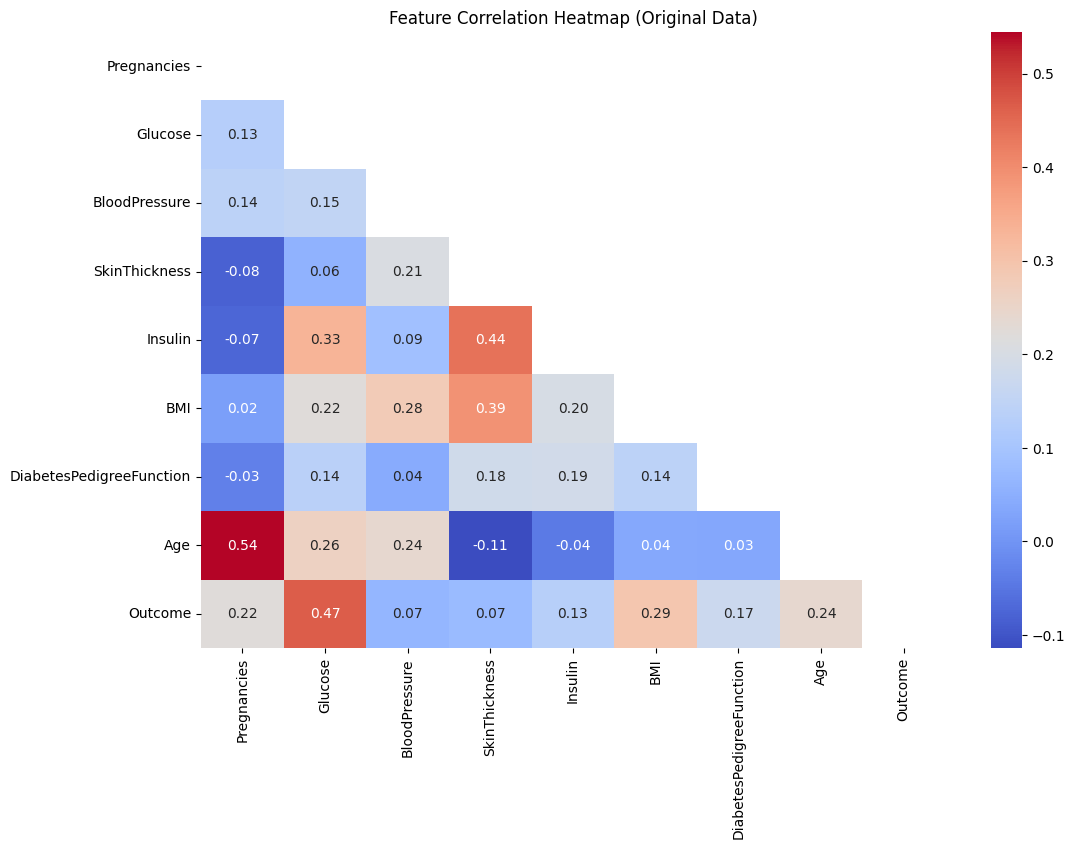

In [8]:
# Cell 3a: Correlation Heatmap
plt.figure(figsize=(12, 8))
corr = diabetes_df.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", mask=np.triu(np.ones_like(corr, dtype=bool)))
plt.title('Feature Correlation Heatmap (Original Data)')
plt.show()

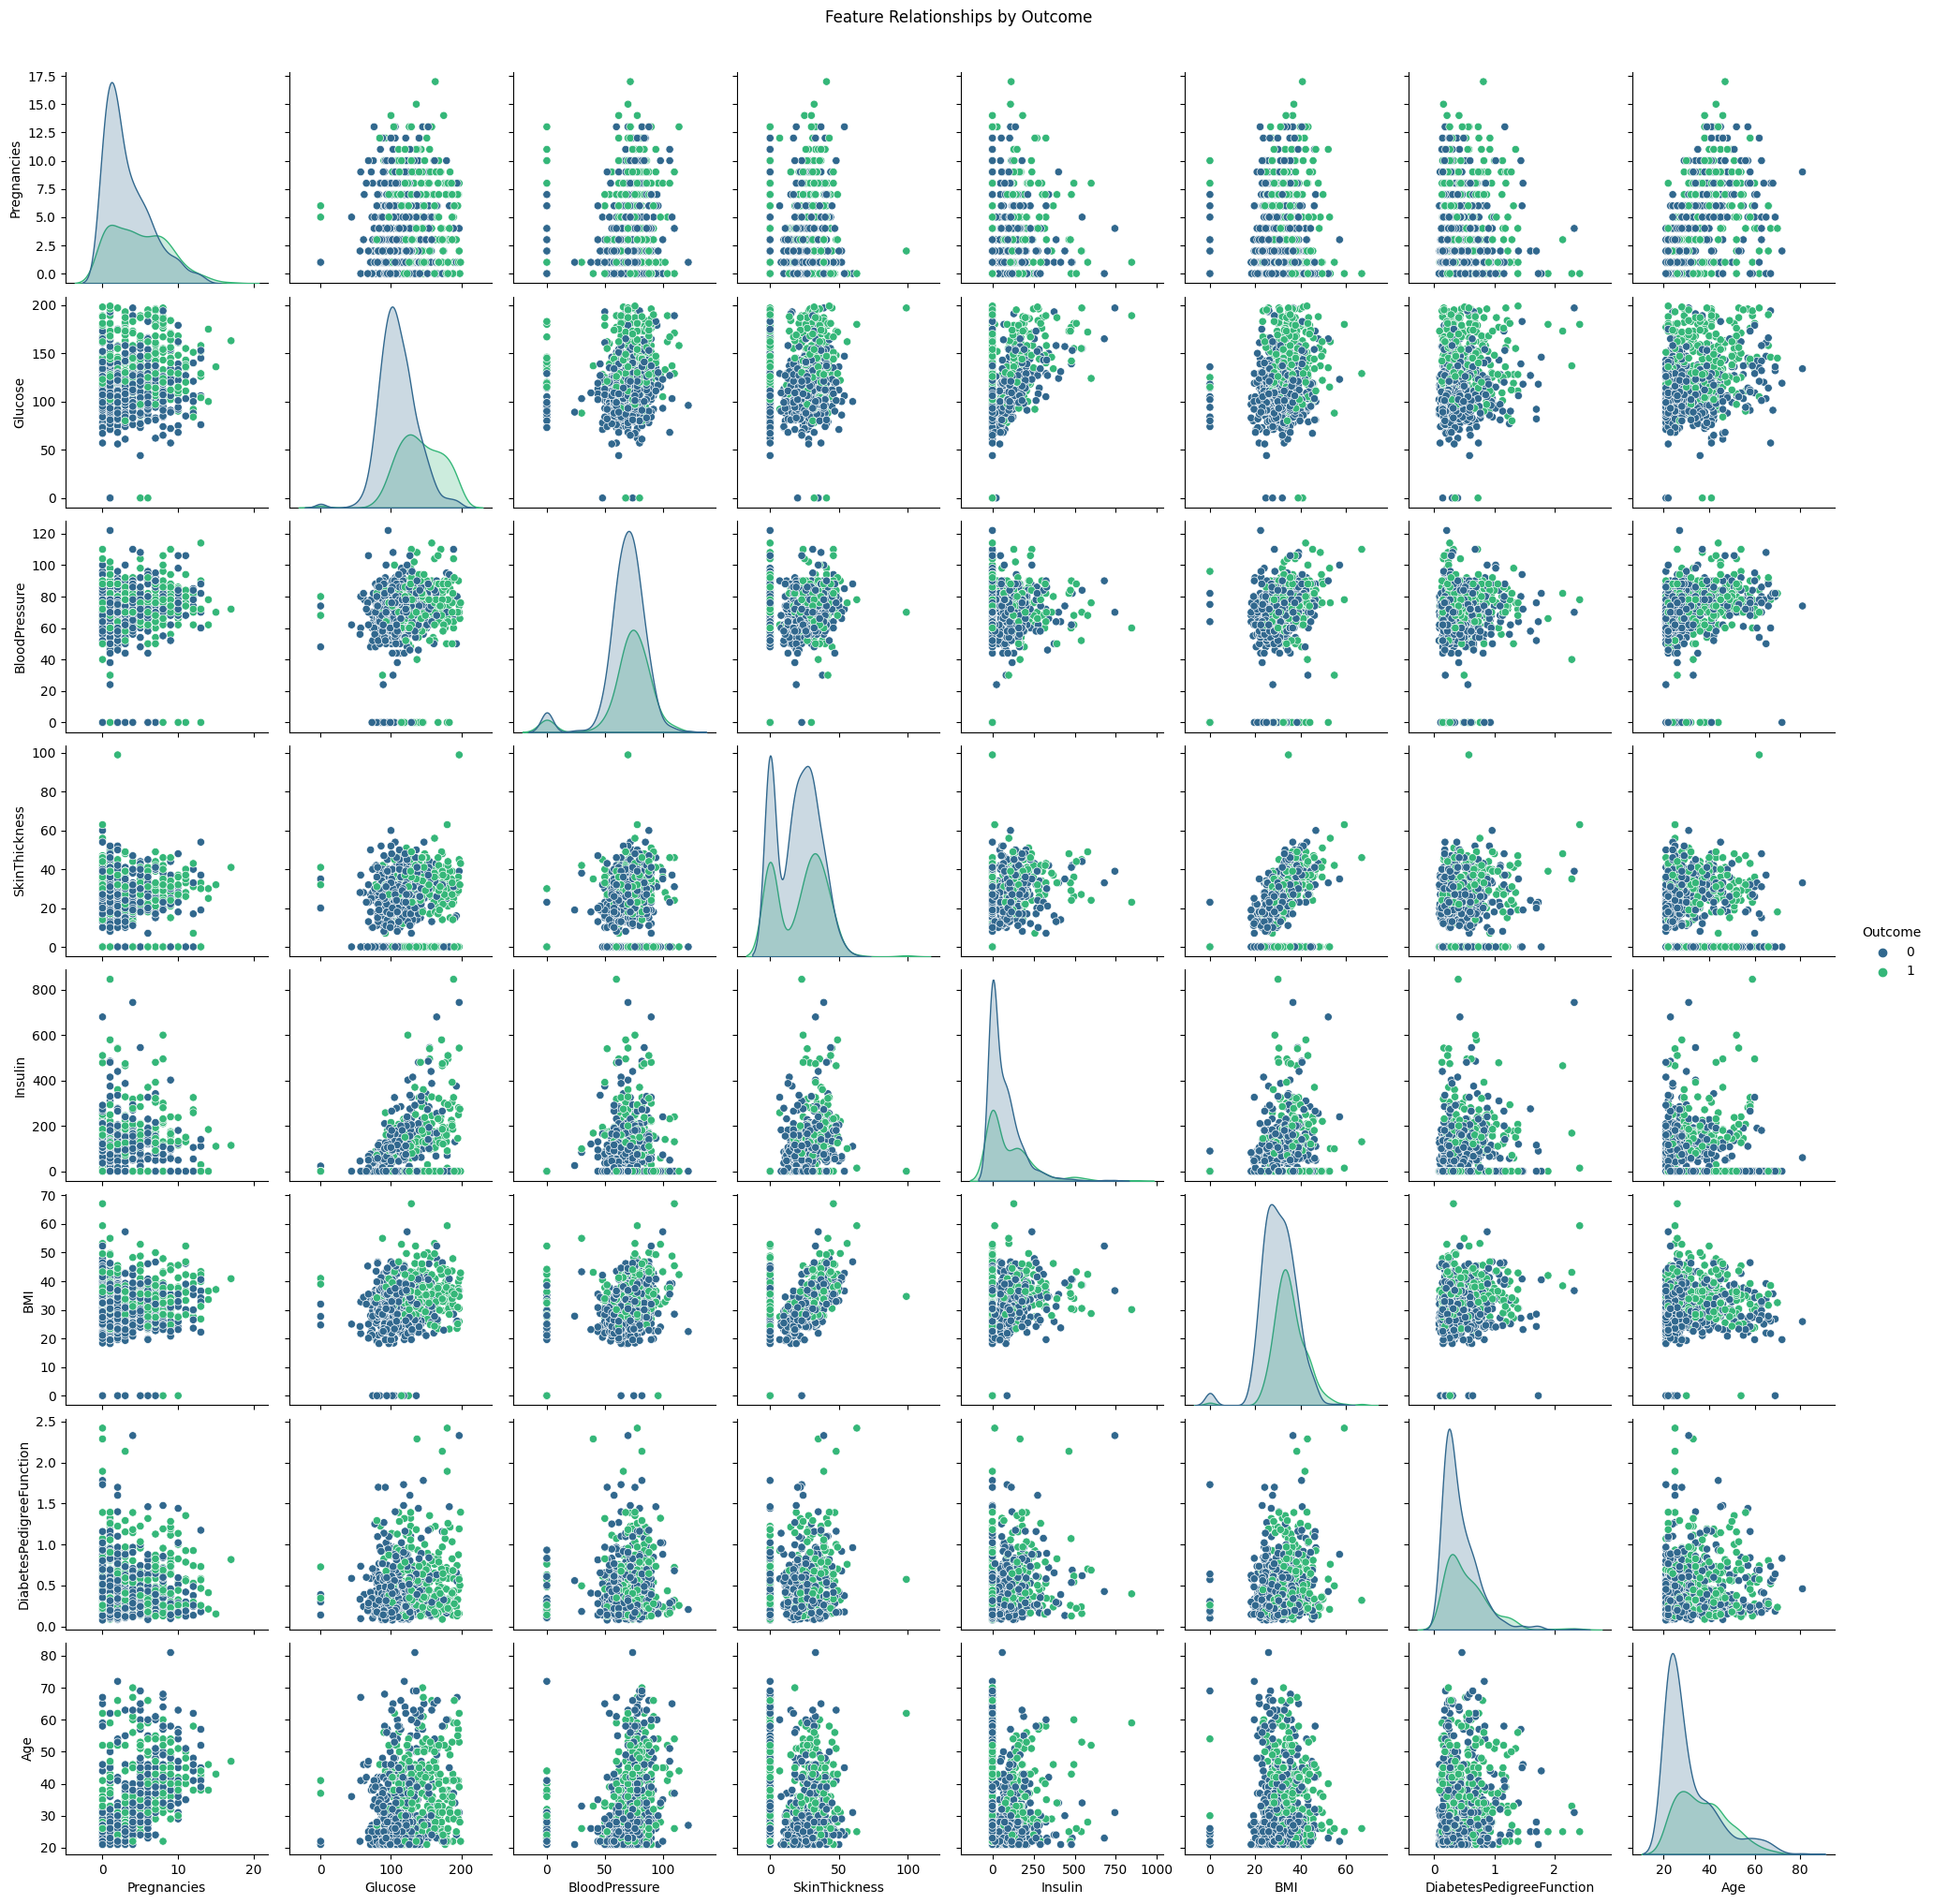

In [9]:
sns.pairplot(diabetes_df, hue='Outcome', palette='viridis')
plt.suptitle('Feature Relationships by Outcome', y=1.02)
plt.show()

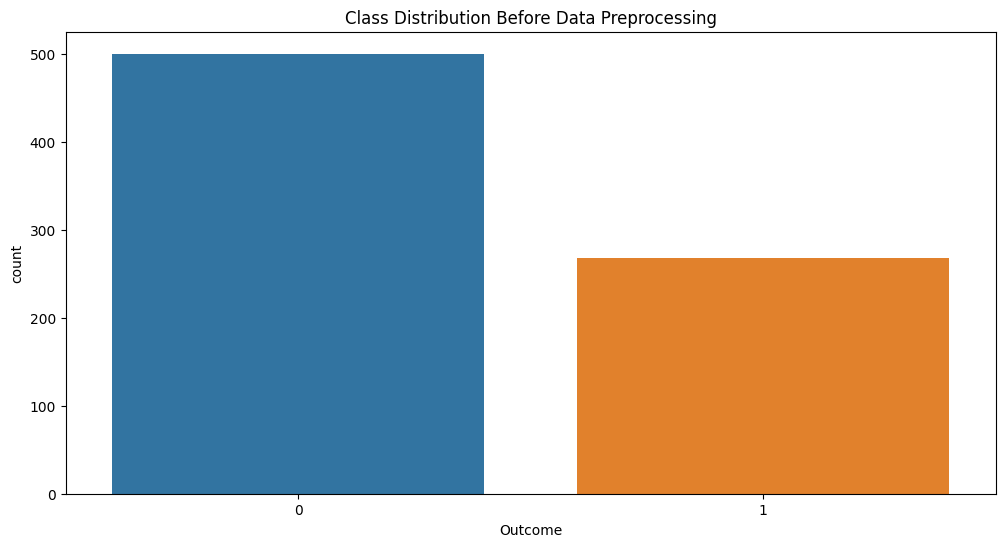

In [10]:
plt.figure(figsize=(12, 6))
sns.countplot(x='Outcome', data=diabetes_df)
plt.title('Class Distribution Before Data Preprocessing')
plt.show()

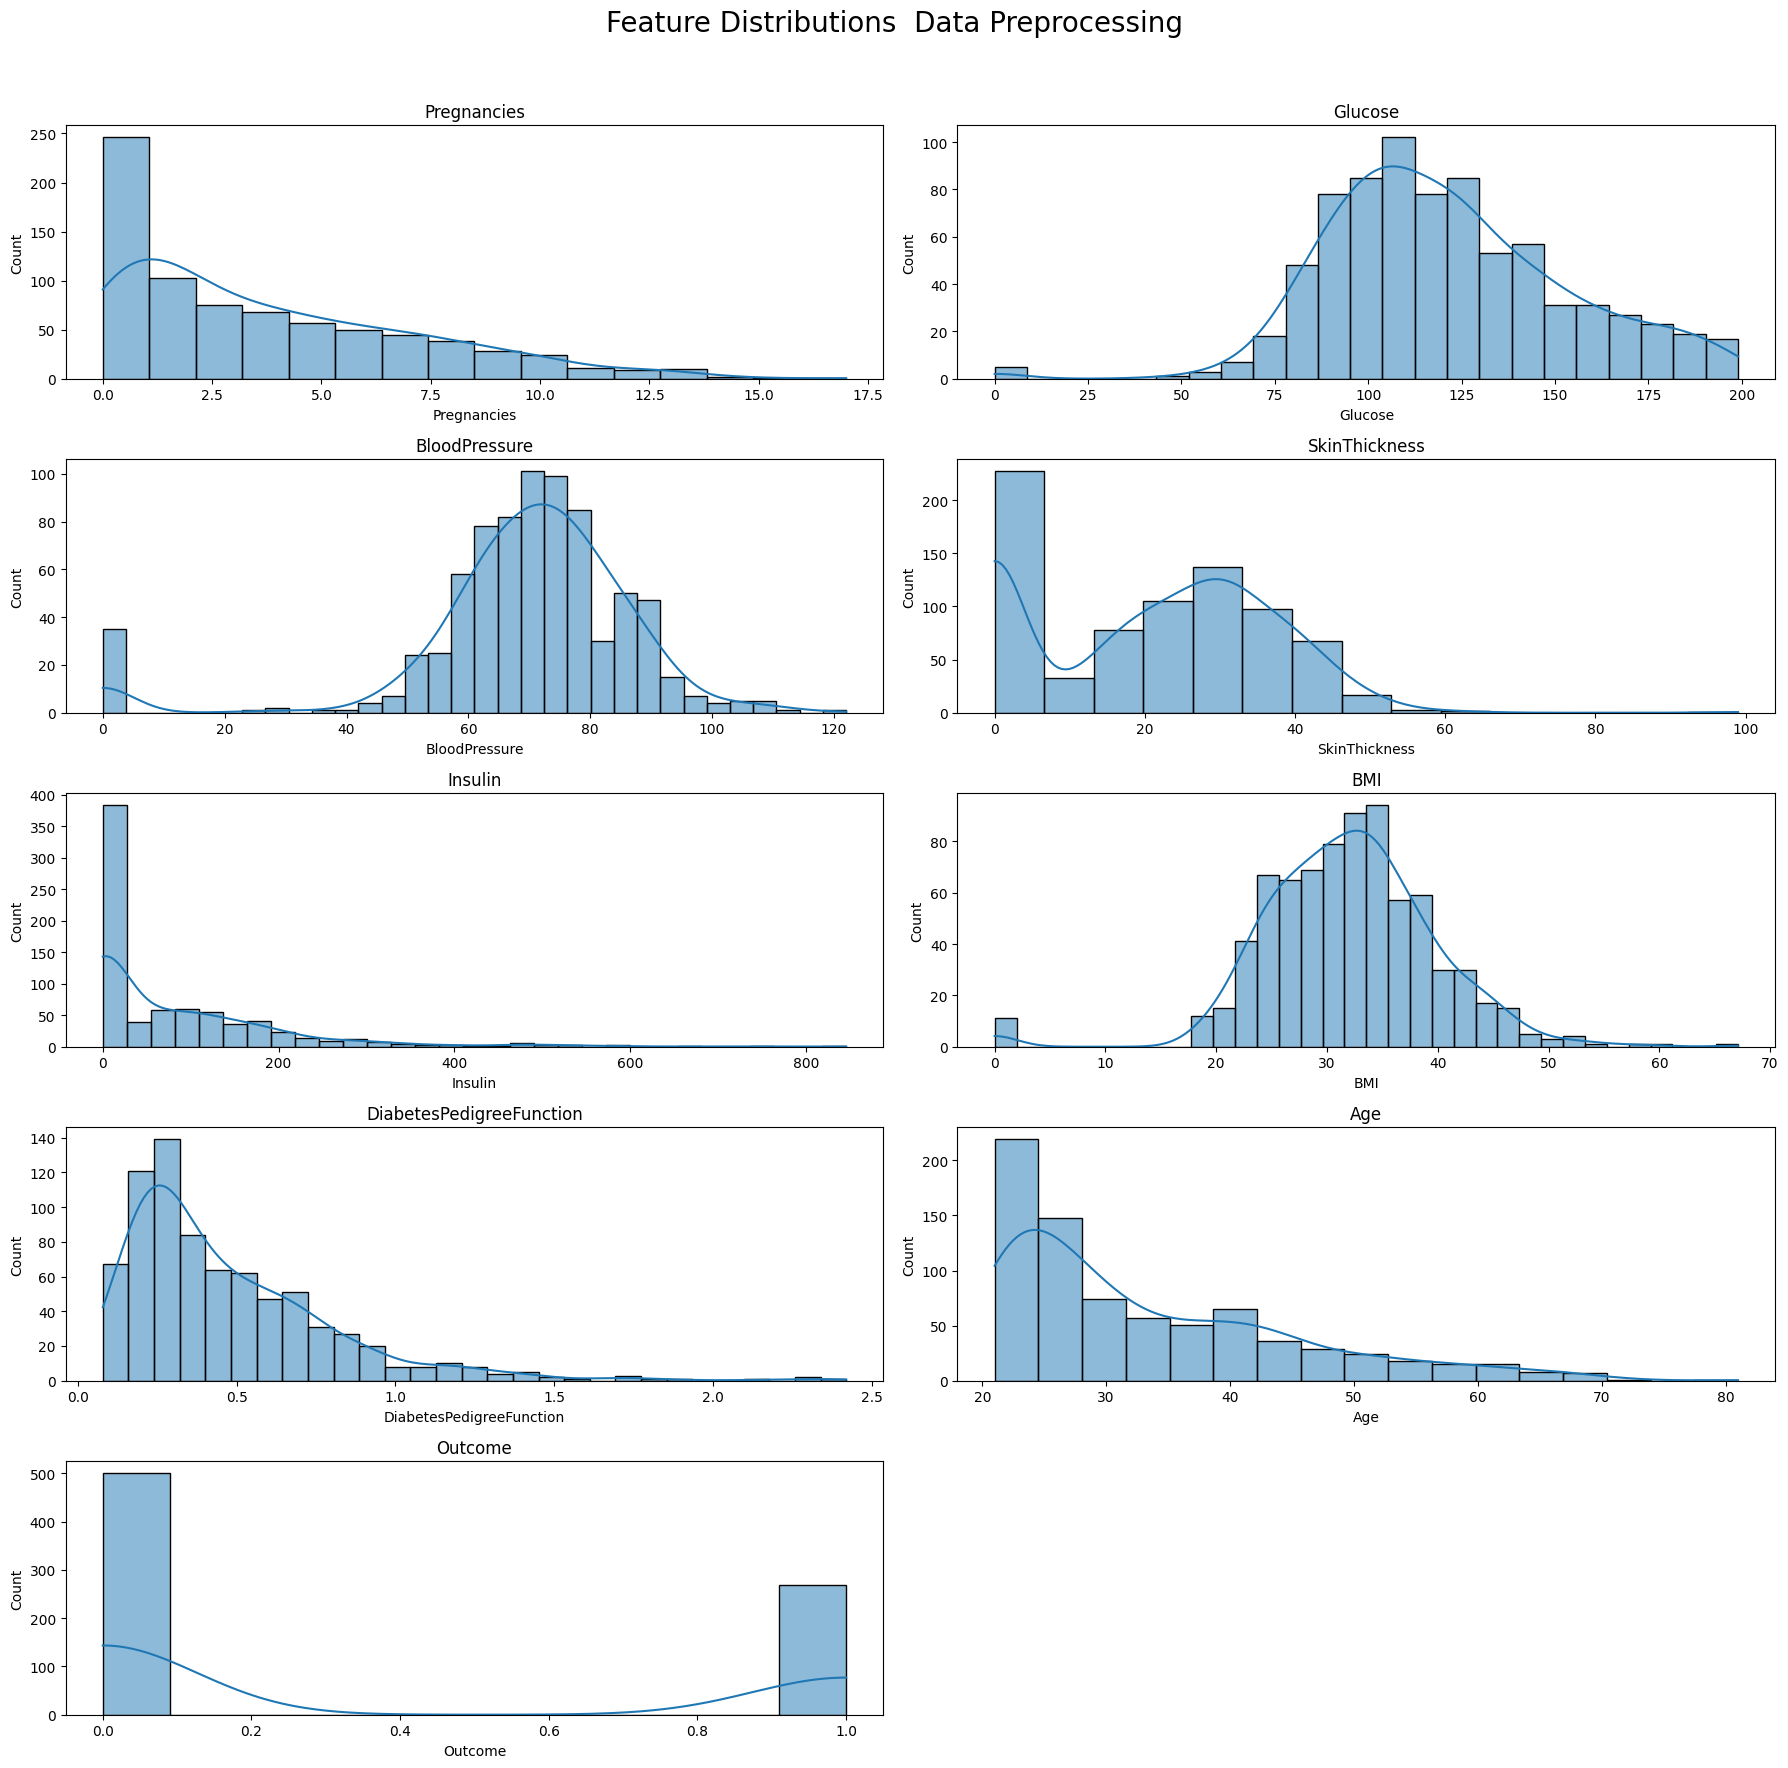

In [11]:
import math
plt.figure(figsize=(18, 18))

num_cols = len(diabetes_df.columns)
num_rows = math.ceil(num_cols / 2)  # 2 plots per row

for i, col in enumerate(diabetes_df.columns):
    plt.subplot(num_rows, 2, i + 1)
    sns.histplot(diabetes_df[col], kde=True)
    plt.title(col)

plt.suptitle('Feature Distributions  Data Preprocessing', fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.96])  # leave space for suptitle
plt.show()

In [12]:
data = diabetes_df.copy()
for col in ['Glucose', 'BMI', 'Age', 'DiabetesPedigreeFunction', 'Insulin']:
    data[col] = data[col].replace(0, np.nan)
    data[col] = data.groupby('Outcome')[col].transform(lambda x: x.fillna(x.median()))

X = data.drop('Outcome', axis=1)
y = data['Outcome']
smote = SMOTE(random_state=SEED)
X_res, y_res = smote.fit_resample(X, y)

scaler = StandardScaler()
X_normalized = scaler.fit_transform(X_res)
X_normalized = pd.DataFrame(X_normalized, columns=X.columns)
X_normalized

Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0       0.631479  0.707532       0.146610       0.874630  0.201161  0.083786   
1      -0.890157 -1.331568      -0.157035       0.501654 -0.560083 -0.974250   
2       1.240134  1.840365      -0.258251      -1.301067  0.201161 -1.473038   
3      -0.890157 -1.202101      -0.157035       0.128677 -0.656659 -0.747528   
4      -1.194485  0.351498      -1.472834       0.874630  0.184118  1.519692   
..           ...       ...            ...            ...       ...       ...   
995     0.327152  1.239056      -0.258251      -1.301067  0.201161 -0.172243   
996    -0.890157 -0.296374      -0.005213       0.563816  0.172851  0.007456   
997    -0.281503  1.668880       0.804509       0.439491  0.080405  0.109179   
998     1.240134 -0.469859       0.602079       0.688142  0.273433  0.170409   
999     0.631479  0.505228      -0.055820       1.123281  0.201161  0.721479   

     DiabetesPedigreeFunction       Age  
0                    0.403313  1.422889  
1                   -0.432028 -0.256818  
2                    0.539510 -0.168413  
3                   -0.988922 -1.140875  
4                    5.430491 -0.080007  
..                        ...       ...  
995                 -0.787367  0.450427  
996                 -0.888069 -0.433630  
997                  1.483900  1.334483  
998                 -0.634004  0.096804  
999                  0.639780  0.715644  

[1000 rows x 8 columns]

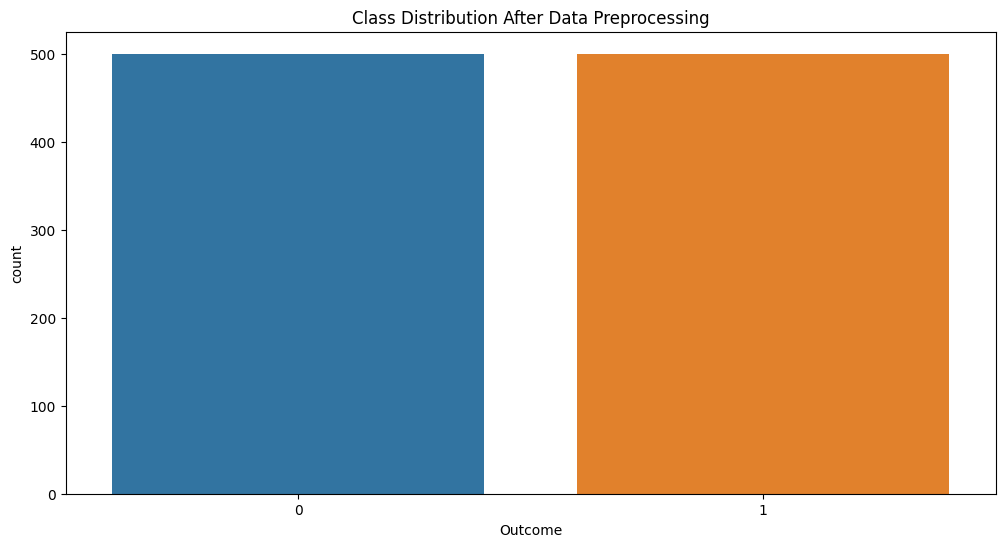

In [13]:
plt.figure(figsize=(12, 6))
sns.countplot(x=y_res)
plt.title('Class Distribution After Data Preprocessing')
plt.show()

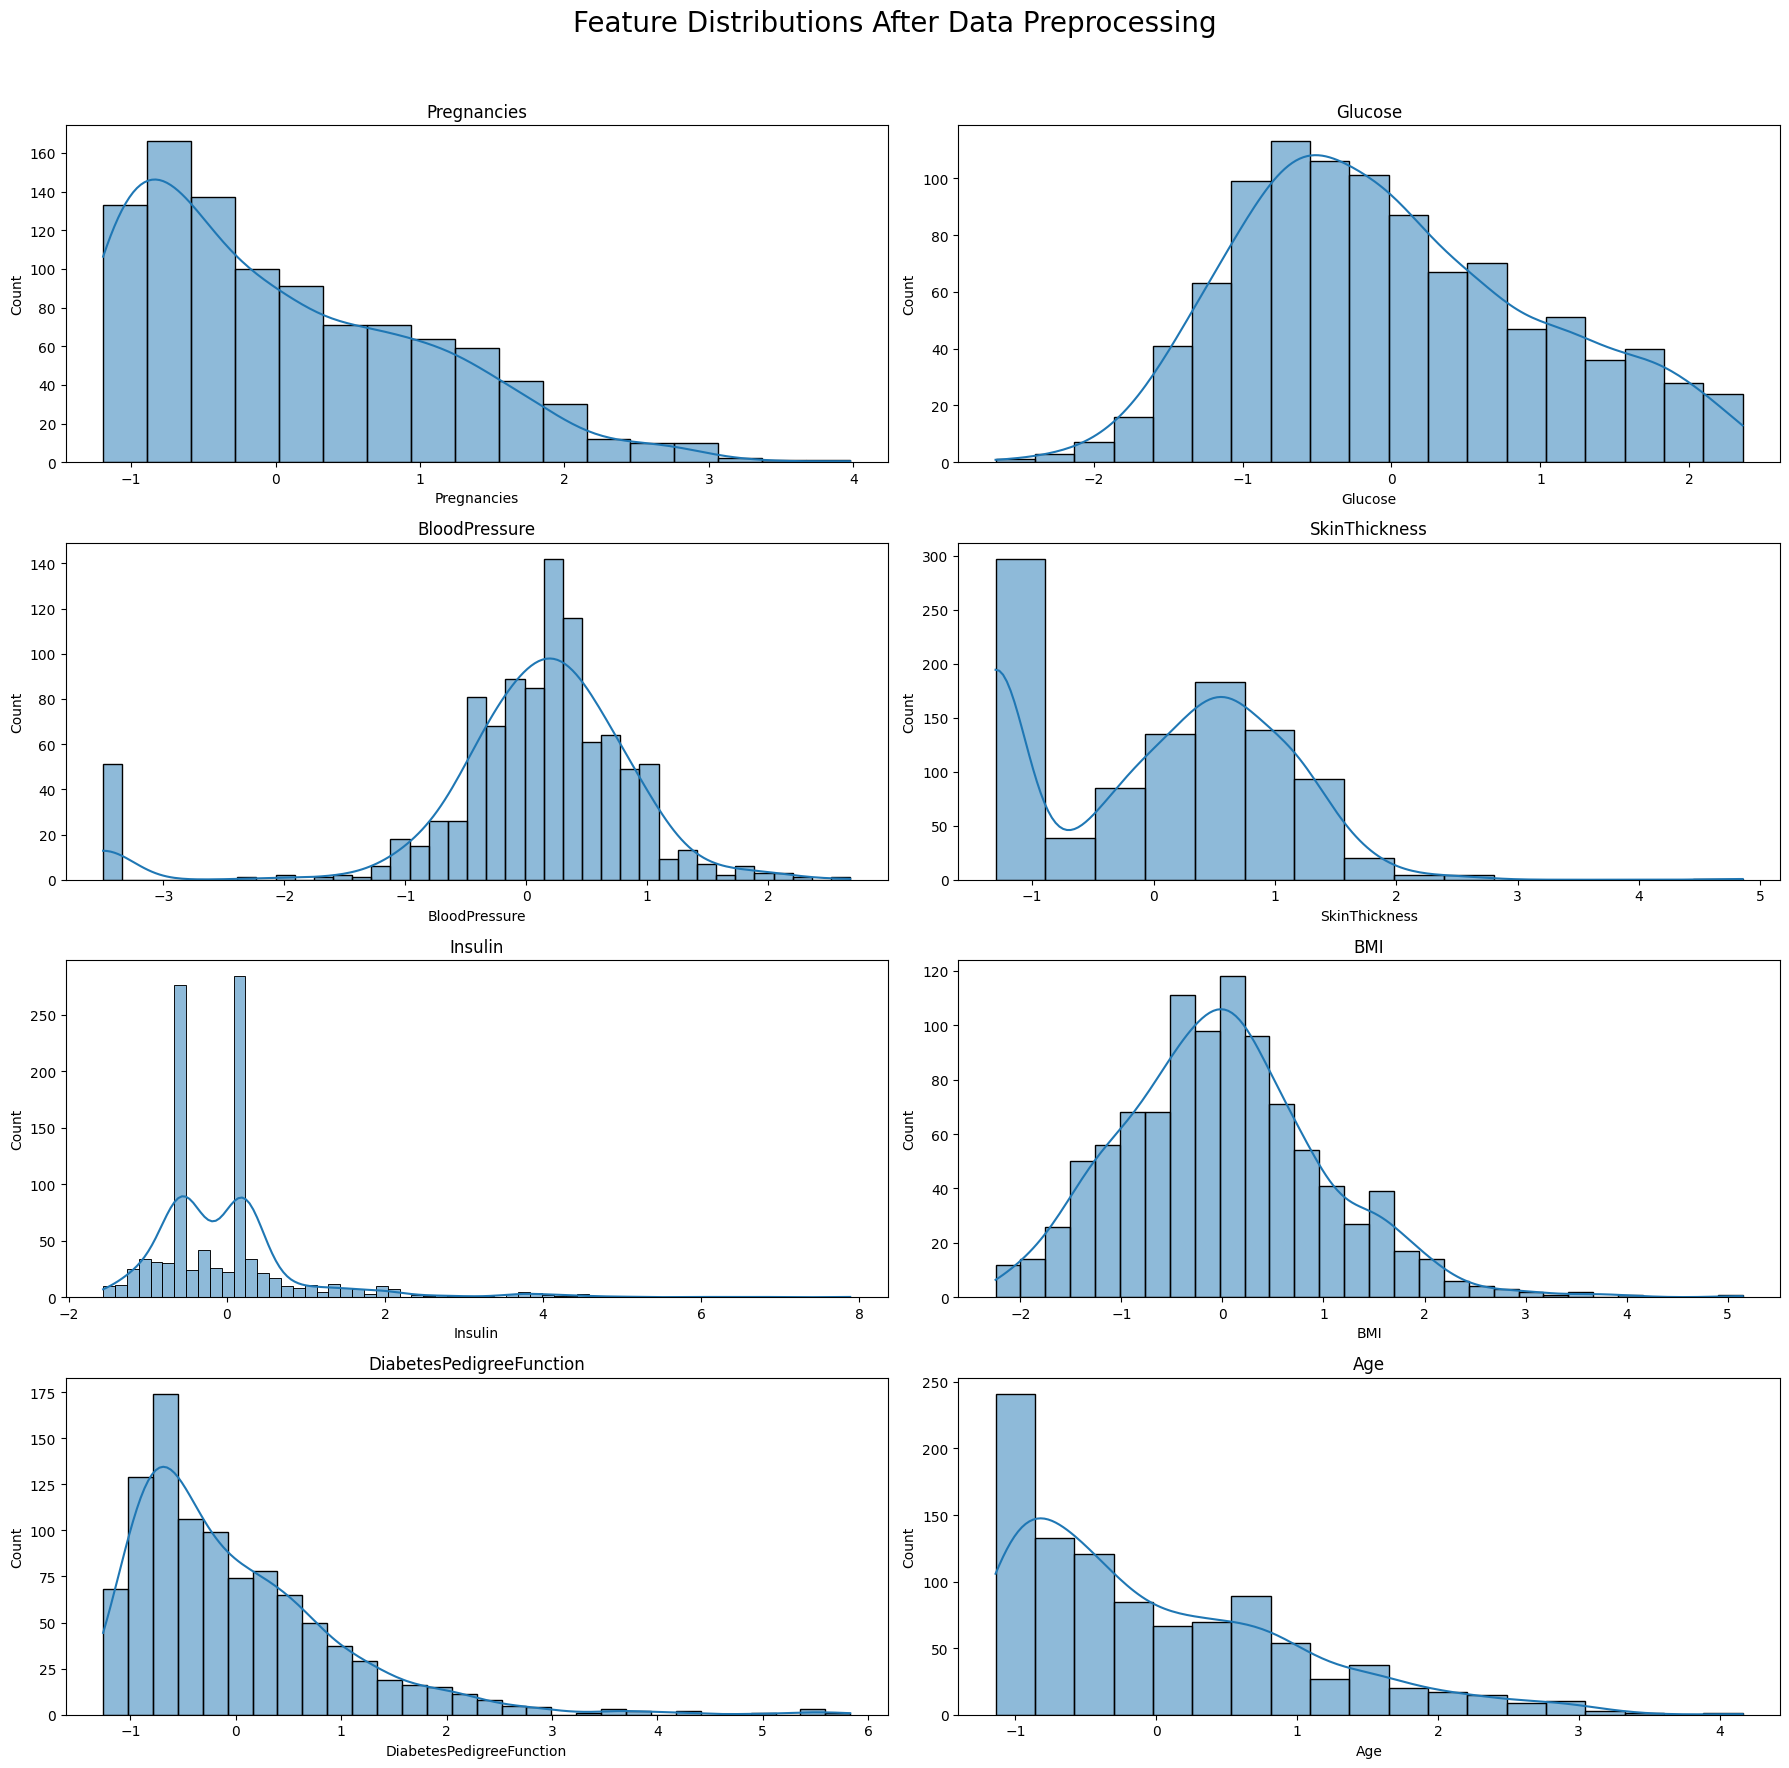

In [14]:
import math
plt.figure(figsize=(18, 18))

num_cols = len(X_normalized.columns)
num_rows = math.ceil(num_cols / 2)  # 2 plots per row

for i, col in enumerate(X_normalized.columns):
    plt.subplot(num_rows, 2, i + 1)
    sns.histplot(X_normalized[col], kde=True)
    plt.title(col)

plt.suptitle('Feature Distributions After Data Preprocessing', fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.96])  
plt.show()

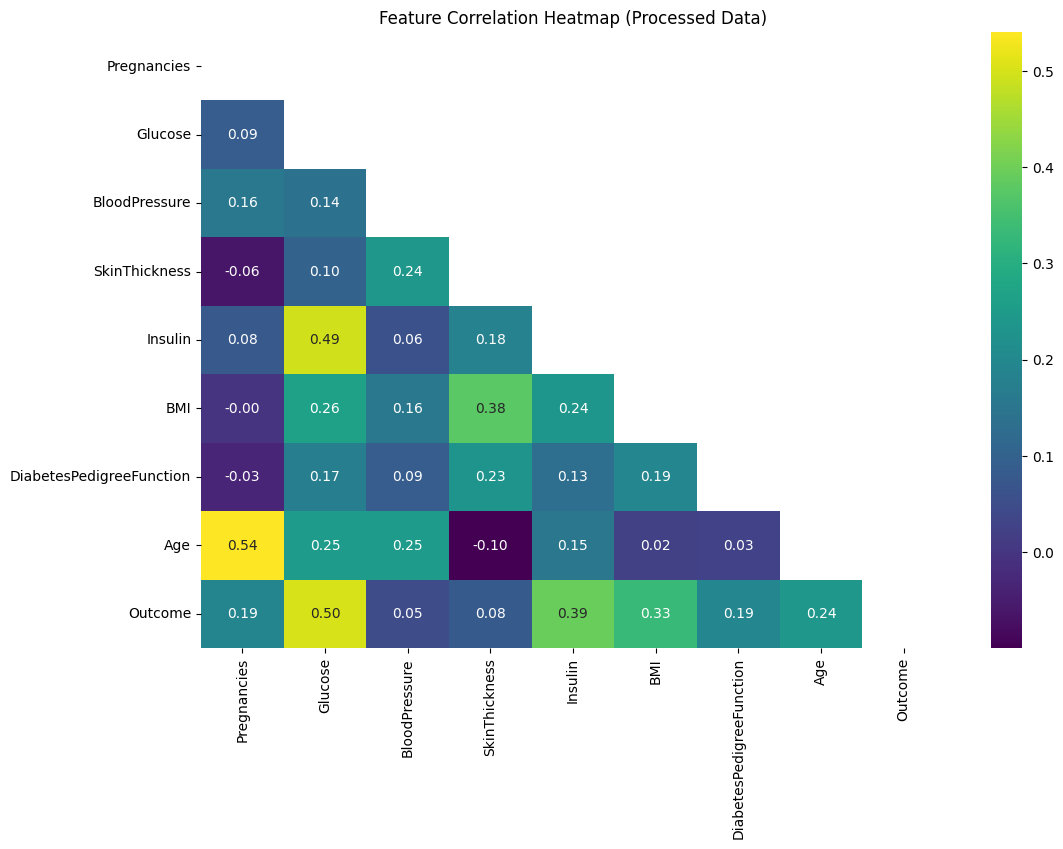

In [15]:
plt.figure(figsize=(12, 8))
corr_post = X_normalized.join(pd.Series(y_res, name='Outcome')).corr()
sns.heatmap(corr_post, annot=True, cmap='viridis', fmt=".2f", mask=np.triu(np.ones_like(corr_post, dtype=bool)))
plt.title('Feature Correlation Heatmap (Processed Data)')
plt.show()

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y_res, test_size=0.2, random_state=SEED)

models = {
    "AdaBoost": AdaBoostClassifier(random_state=42, algorithm='SAMME'),
    "XGBoost": XGBClassifier(random_state=42, eval_metric='logloss'),
    "RandomForest": RandomForestClassifier(random_state=42),
    "GBM": GradientBoostingClassifier(random_state=42),
}



In [17]:
rf = RandomForestClassifier(
    n_estimators=500,  
    max_depth=7,       
    min_samples_leaf=5, 
    random_state=42
)

boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42, perc=95) 

print("\nRunning Stabilized Boruta Feature Selection:")
boruta.fit(X_train.values, y_train.values)

support_mask = boruta.support_
selected_indices = np.where(support_mask)[0]

if len(selected_indices) > 5:
    rf_temp = RandomForestClassifier(
        n_estimators=1000,  
        max_depth=None,     
        random_state=42
    )
    rf_temp.fit(X_train.iloc[:, selected_indices], y_train)
    importances = rf_temp.feature_importances_
    top_5_indices = selected_indices[np.argsort(importances)[::-1][:5]]
else:
    top_5_indices = selected_indices

selected_features = X.columns[top_5_indices].tolist()
print("\nConsistent Final Features:", selected_features)


Running Stabilized Boruta Feature Selection:
Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	8
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	8
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	8
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	8
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	8
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	8
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	8
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	6
Tentative: 	2
Rejected: 	0
Iteration: 	9 / 100
Confirmed: 	6
Tentative: 	2
Rejected: 	0
Iteration: 	10 / 100
Confirmed: 	6
Tentative: 	2
Rejected: 	0
Iteration: 	11 / 100
Confirmed: 	6
Tentative: 	2
Rejected: 	0
Iteration: 	12 / 100
Confirmed: 	7
Tentative: 	1
Rejected: 	0
Iteration: 	13 / 100
Confirmed: 	7
Tentative: 	1
Rejected: 	0
Iteration: 	14 / 100
Confirmed: 	7
Tentative: 	1
Rejected: 	0
Iteration: 	15 / 100
Confirmed: 	7
Tentative: 	1
Rejected: 	0
Iteration: 	16 / 100
Confirmed: 	

In [18]:
feature_ranges = {col: (X_normalized[col].min(), X_normalized[col].max()) for col in X_normalized}
feature_ranges

{'Pregnancies': (-1.1944846375563234, 3.9790793977194725),
 'Glucose': (-2.658601107057649, 2.3582313605426157),
 'BloodPressure': (-3.4971387119322386, 2.6769915408170366),
 'SkinThickness': (-1.3010667991539586, 4.8530475398924775),
 'Insulin': (-1.5656073507941304, 7.887455948618908),
 'BMI': (-2.2438930083459154, 5.147243948066296),
 'DiabetesPedigreeFunction': (-1.258288877892533, 5.830002112072932),
 'Age': (-1.1408745866692716, 4.16346289493912)}


Generating SHAP plot...


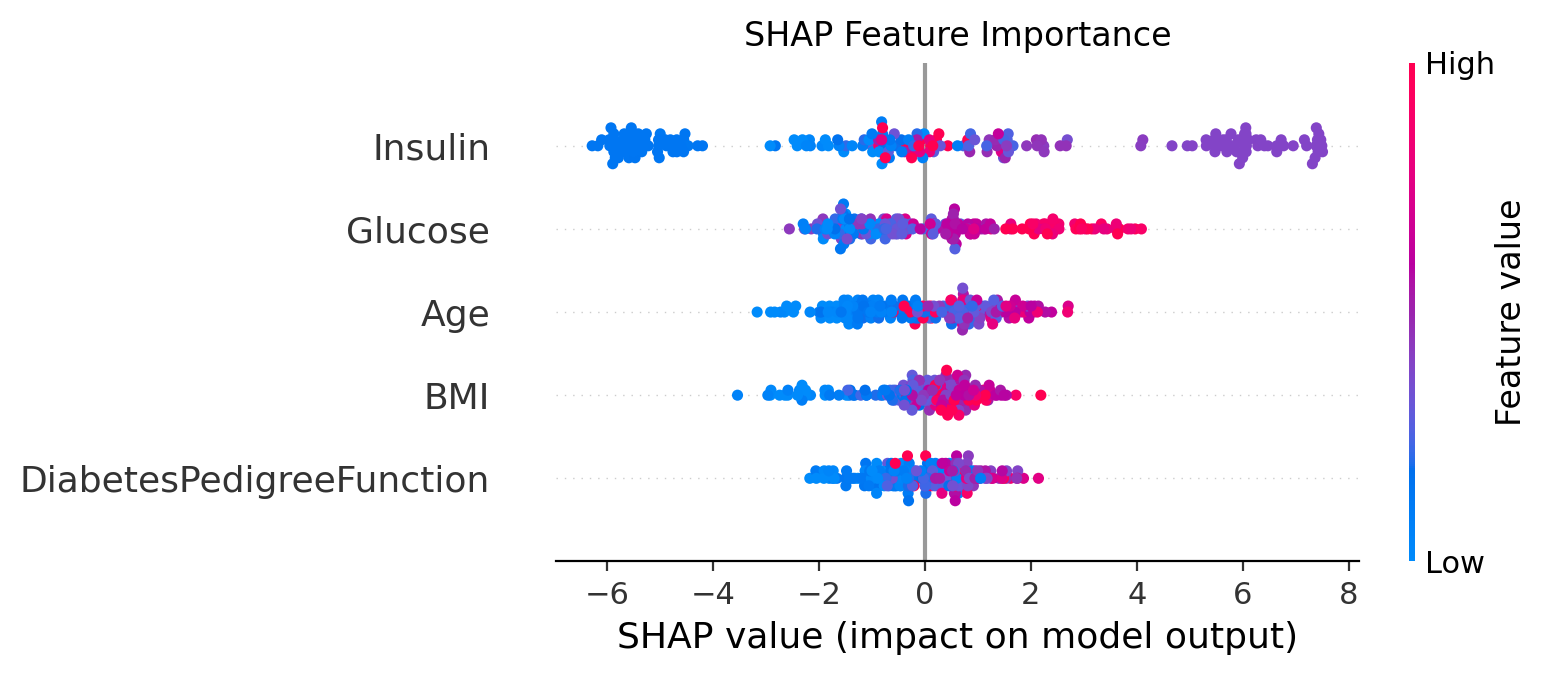

In [19]:
%config InlineBackend.figure_format = 'retina'  

X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

print("\nGenerating SHAP plot...")
xgb_model = XGBClassifier(n_estimators=100, random_state=42, eval_metric='logloss')
xgb_model.fit(X_train_selected, y_train)

explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_test_selected)

plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test_selected, show=False)
plt.title("SHAP Feature Importance")
plt.tight_layout()
plt.show()

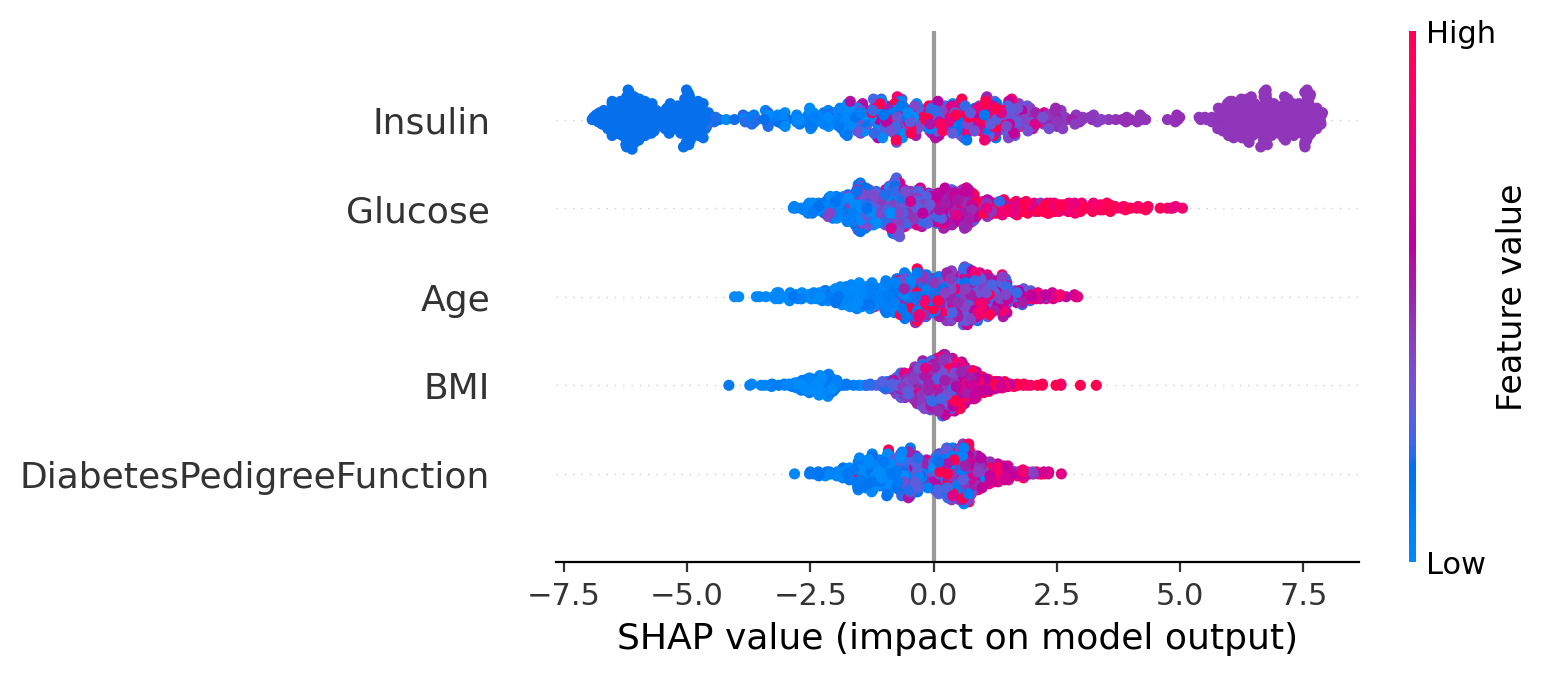

In [20]:
%config InlineBackend.figure_format = 'retina'

X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

X_full = pd.concat([X_train_selected, X_test_selected])
y_full = pd.concat([y_train, y_test])

xgb_model = XGBClassifier(n_estimators=100, random_state=42, eval_metric='logloss')
xgb_model.fit(X_full, y_full)

explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_full)

plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_full)
plt.show()

In [21]:
X_normalized_sel = X_normalized[selected_features]
X_normalized_sel

Insulin   Glucose       BMI       Age  DiabetesPedigreeFunction
0    0.201161  0.707532  0.083786  1.422889                  0.403313
1   -0.560083 -1.331568 -0.974250 -0.256818                 -0.432028
2    0.201161  1.840365 -1.473038 -0.168413                  0.539510
3   -0.656659 -1.202101 -0.747528 -1.140875                 -0.988922
4    0.184118  0.351498  1.519692 -0.080007                  5.430491
..        ...       ...       ...       ...                       ...
995  0.201161  1.239056 -0.172243  0.450427                 -0.787367
996  0.172851 -0.296374  0.007456 -0.433630                 -0.888069
997  0.080405  1.668880  0.109179  1.334483                  1.483900
998  0.273433 -0.469859  0.170409  0.096804                 -0.634004
999  0.201161  0.505228  0.721479  0.715644                  0.639780

[1000 rows x 5 columns]

Model Performance with Selected Features:


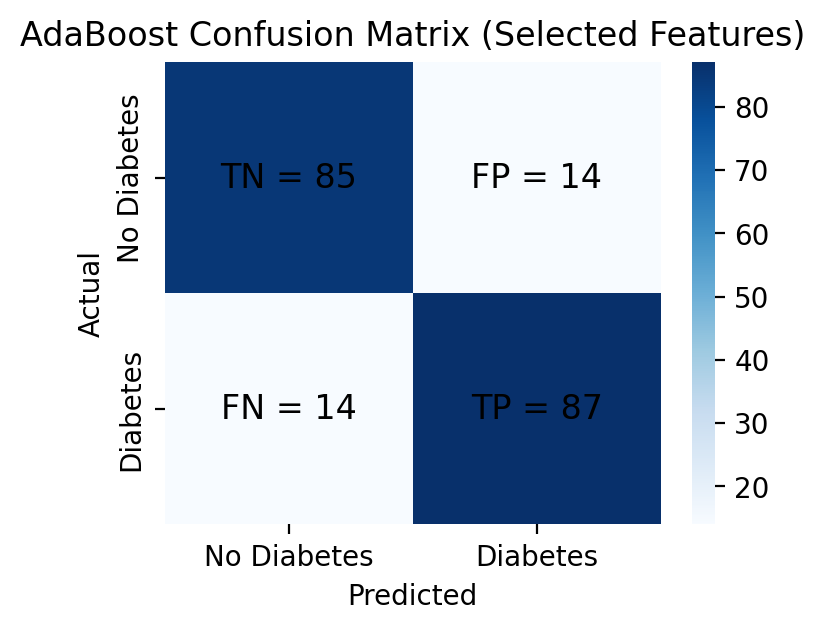


AdaBoost Metrics (Selected Features):
+---------------------------+---------+
| Metric                    |   Value |
+===========================+=========+
| Accuracy                  |  0.86   |
+---------------------------+---------+
| Precision                 |  0.8614 |
+---------------------------+---------+
| Recall (TPR)              |  0.8614 |
+---------------------------+---------+
| F1-Score                  |  0.8614 |
+---------------------------+---------+
| False Positive Rate (FPR) |  0.1414 |
+---------------------------+---------+
| Error Rate                |  0.14   |
+---------------------------+---------+
| AUC-ROC                   |  0.9294 |
+---------------------------+---------+




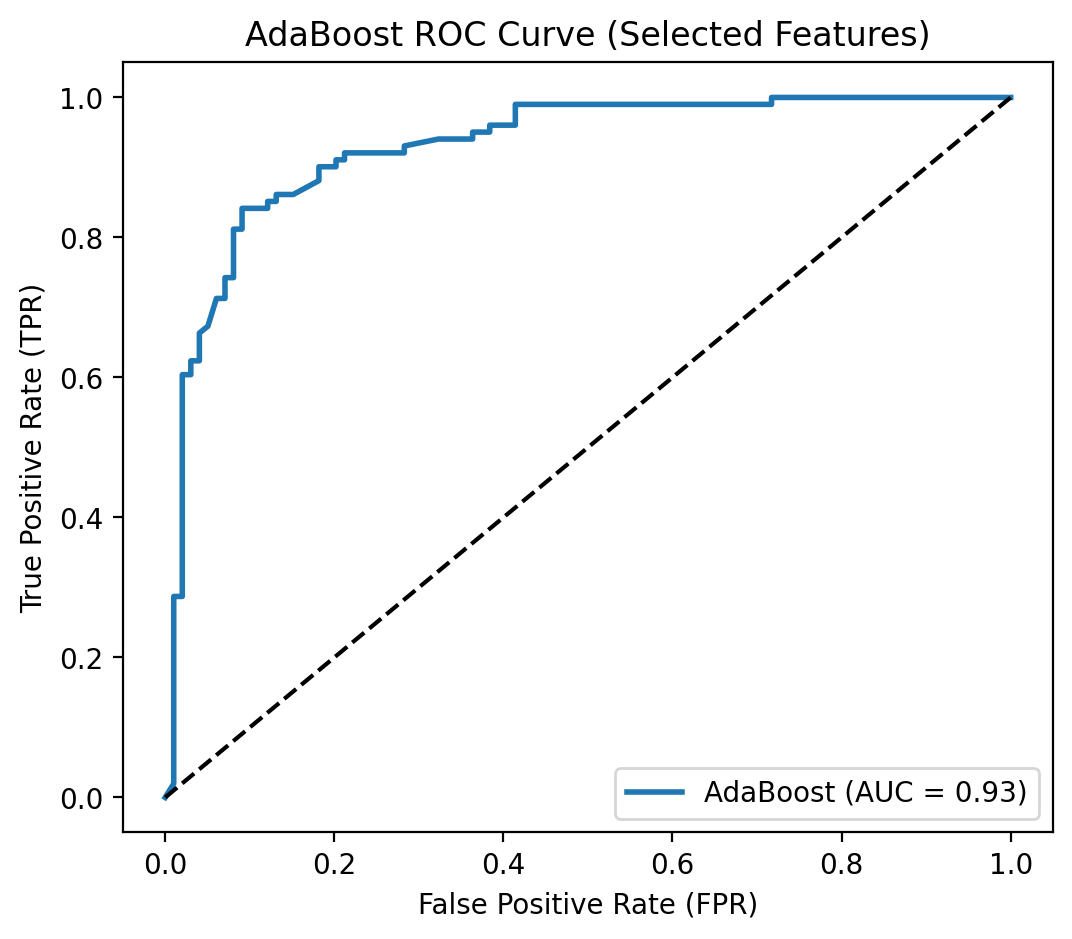

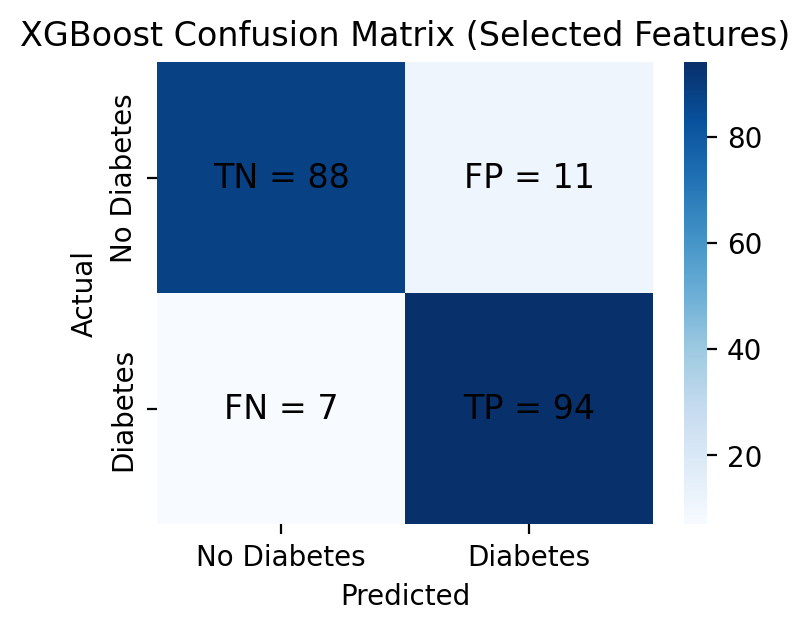


XGBoost Metrics (Selected Features):
+---------------------------+---------+
| Metric                    |   Value |
+===========================+=========+
| Accuracy                  |  0.91   |
+---------------------------+---------+
| Precision                 |  0.8952 |
+---------------------------+---------+
| Recall (TPR)              |  0.9307 |
+---------------------------+---------+
| F1-Score                  |  0.9126 |
+---------------------------+---------+
| False Positive Rate (FPR) |  0.1111 |
+---------------------------+---------+
| Error Rate                |  0.09   |
+---------------------------+---------+
| AUC-ROC                   |  0.9645 |
+---------------------------+---------+




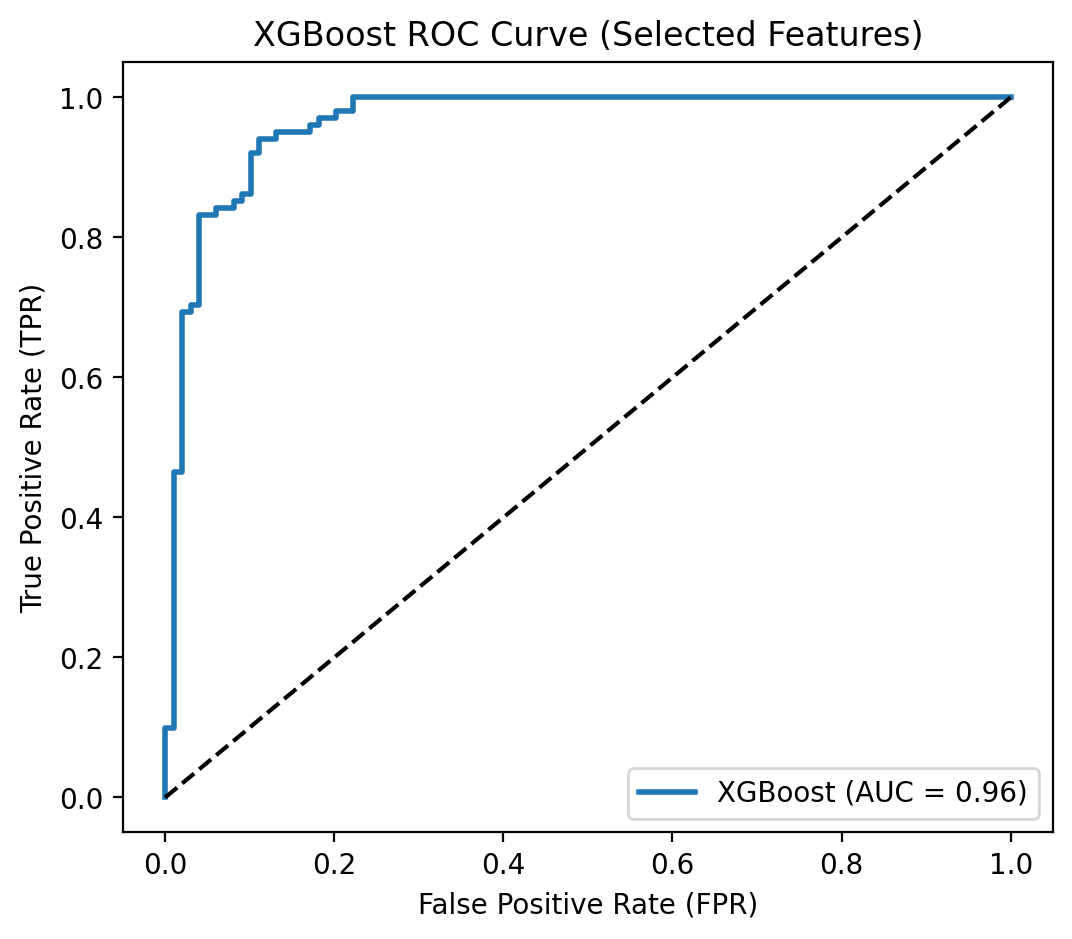

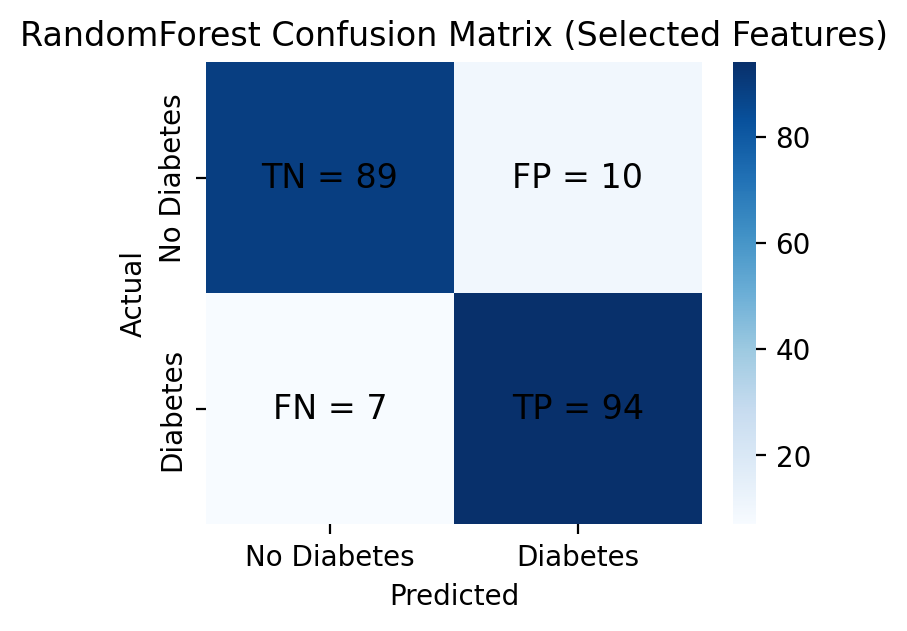


RandomForest Metrics (Selected Features):
+---------------------------+---------+
| Metric                    |   Value |
+===========================+=========+
| Accuracy                  |  0.915  |
+---------------------------+---------+
| Precision                 |  0.9038 |
+---------------------------+---------+
| Recall (TPR)              |  0.9307 |
+---------------------------+---------+
| F1-Score                  |  0.9171 |
+---------------------------+---------+
| False Positive Rate (FPR) |  0.101  |
+---------------------------+---------+
| Error Rate                |  0.085  |
+---------------------------+---------+
| AUC-ROC                   |  0.9659 |
+---------------------------+---------+




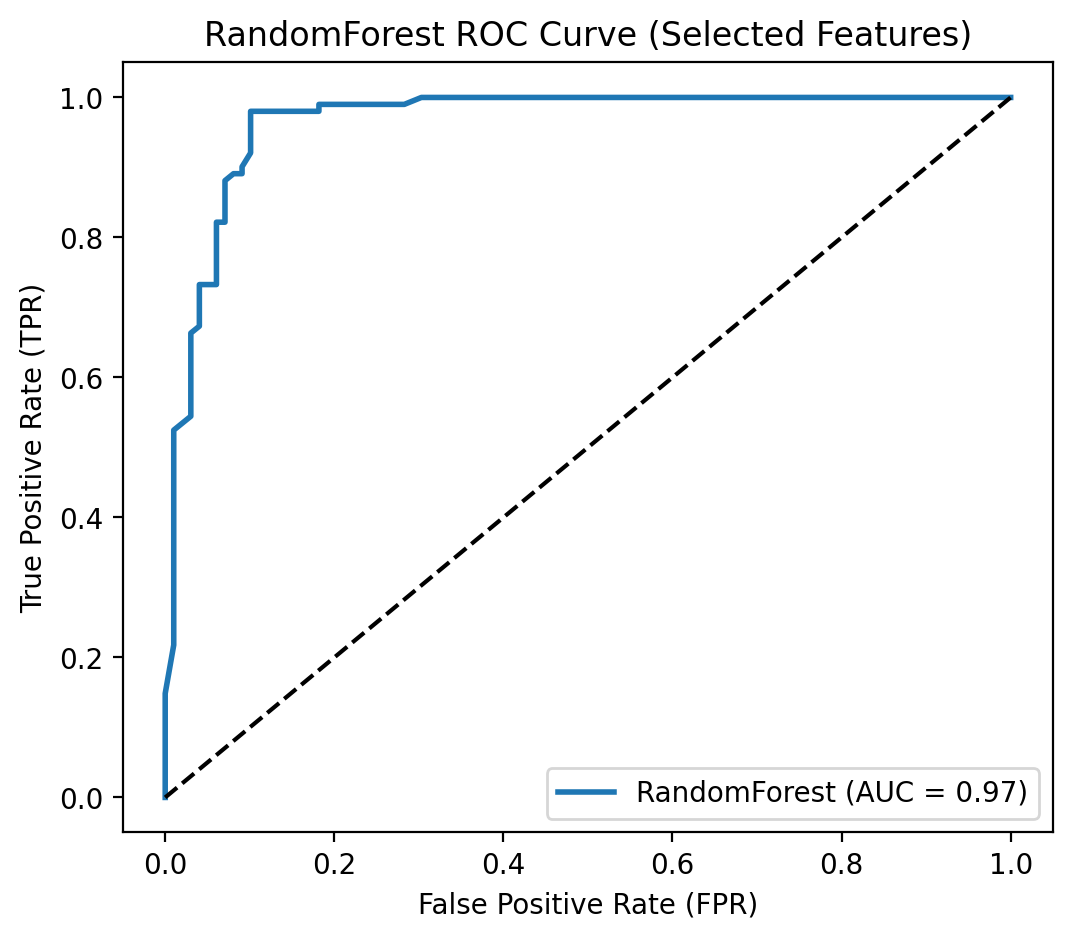

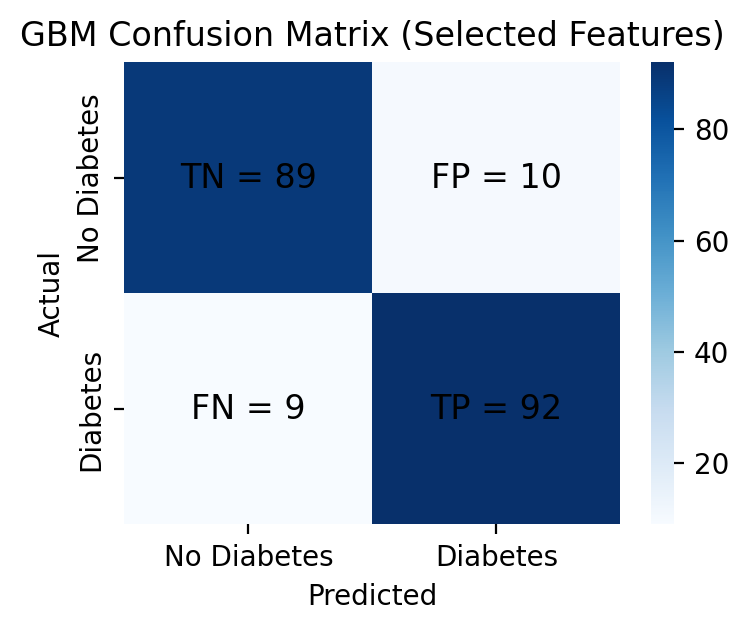


GBM Metrics (Selected Features):
+---------------------------+---------+
| Metric                    |   Value |
+===========================+=========+
| Accuracy                  |  0.905  |
+---------------------------+---------+
| Precision                 |  0.902  |
+---------------------------+---------+
| Recall (TPR)              |  0.9109 |
+---------------------------+---------+
| F1-Score                  |  0.9064 |
+---------------------------+---------+
| False Positive Rate (FPR) |  0.101  |
+---------------------------+---------+
| Error Rate                |  0.095  |
+---------------------------+---------+
| AUC-ROC                   |  0.9532 |
+---------------------------+---------+




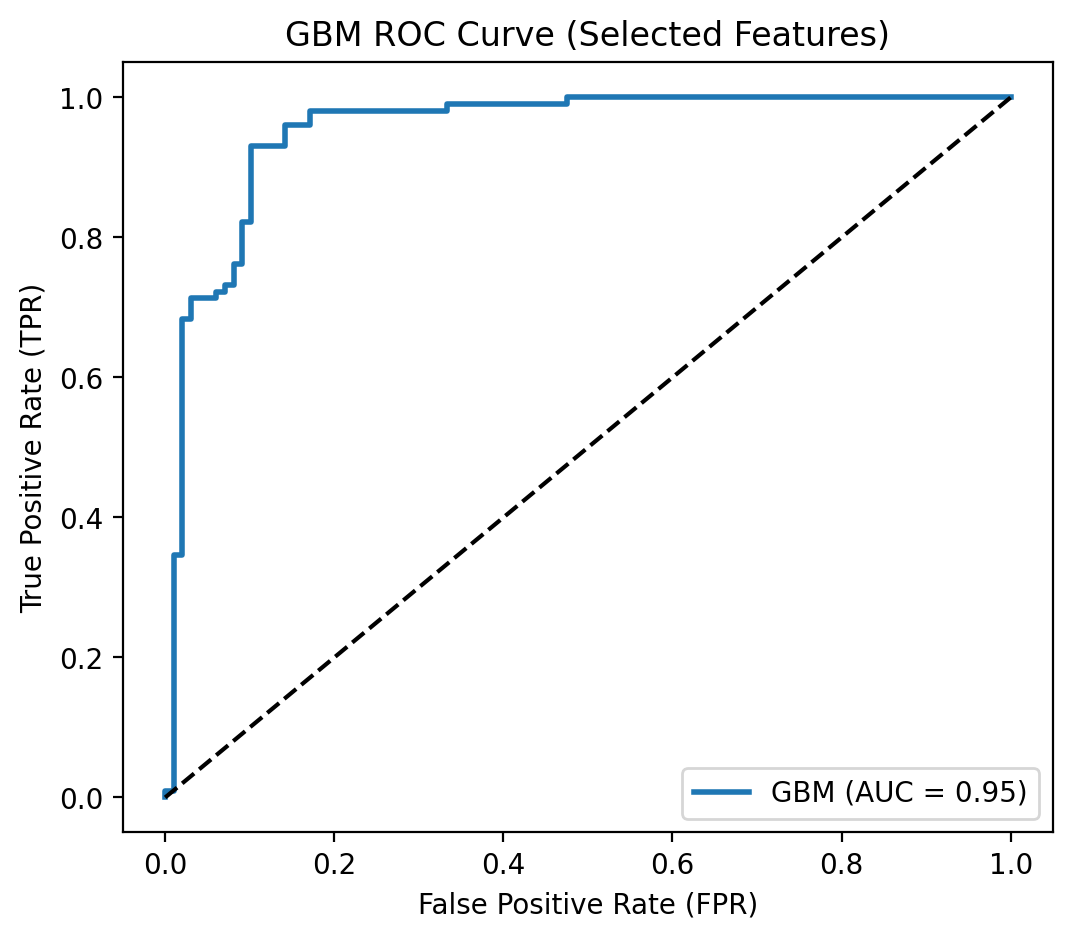


Summary of Model Performance (Selected Features):
+--------------+------------+-------------+----------------+------------+--------+--------+--------------+-----------+
| Model        |   Accuracy |   Precision |   Recall (TPR) |   F1-Score |    TPR |    FPR |   Error Rate |   AUC-ROC |
+==============+============+=============+================+============+========+========+==============+===========+
| AdaBoost     |      0.86  |      0.8614 |         0.8614 |     0.8614 | 0.8614 | 0.1414 |        0.14  |    0.9294 |
+--------------+------------+-------------+----------------+------------+--------+--------+--------------+-----------+
| XGBoost      |      0.91  |      0.8952 |         0.9307 |     0.9126 | 0.9307 | 0.1111 |        0.09  |    0.9645 |
+--------------+------------+-------------+----------------+------------+--------+--------+--------------+-----------+
| RandomForest |      0.915 |      0.9038 |         0.9307 |     0.9171 | 0.9307 | 0.101  |        0.085 |    0.9659

In [22]:
X_train_sel = X_train[selected_features]
X_test_sel = X_test[selected_features]

print("Model Performance with Selected Features:")

final_results_sel = []

for name, model in models.items():
    model.fit(X_train_sel, y_train)
    
    # Predictions
    y_pred = model.predict(X_test_sel)
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    TN, FP, FN, TP = cm.ravel()
    
    # Metrics Calculation
    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)  # Same as TPR
    f1 = f1_score(y_test, y_pred)
    tpr = recall  # TPR = Recall
    fpr = FP / (FP + TN)  # False Positive Rate
    error_rate = (FP + FN) / (TP + TN + FP + FN)  # Error Rate
    
    # ROC Curve and AUC
    fpr_roc, tpr_roc, _ = roc_curve(y_test, model.predict_proba(X_test_sel)[:, 1])
    auc_roc = roc_auc_score(y_test, model.predict_proba(X_test_sel)[:, 1])
    
    # Append metrics to final_results_sel for the overall summary
    final_results_sel.append([
        name, 
        f"{acc:.4f}", 
        f"{precision:.4f}", 
        f"{recall:.4f}", 
        f"{f1:.4f}", 
        f"{tpr:.4f}", 
        f"{fpr:.4f}", 
        f"{error_rate:.4f}", 
        f"{auc_roc:.4f}"
    ])
    
    # Plotting Confusion Matrix
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=False, fmt='d', cmap='Blues',
                xticklabels=['No Diabetes', 'Diabetes'],
                yticklabels=['No Diabetes', 'Diabetes'])
    
    # Annotate TN, FP, FN, TP
    plt.text(0.5, 0.5, f'TN = {TN}', ha='center', va='center', color='black', fontsize=12)
    plt.text(1.5, 0.5, f'FP = {FP}', ha='center', va='center', color='black', fontsize=12)
    plt.text(0.5, 1.5, f'FN = {FN}', ha='center', va='center', color='black', fontsize=12)
    plt.text(1.5, 1.5, f'TP = {TP}', ha='center', va='center', color='black', fontsize=12)
    
    plt.title(f'{name} Confusion Matrix (Selected Features)')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    # Display metrics in a table right after the confusion matrix
    metrics_table = [
        ["Accuracy", f"{acc:.4f}"],
        ["Precision", f"{precision:.4f}"],
        ["Recall (TPR)", f"{recall:.4f}"],
        ["F1-Score", f"{f1:.4f}"],
        ["False Positive Rate (FPR)", f"{fpr:.4f}"],
        ["Error Rate", f"{error_rate:.4f}"],
        ["AUC-ROC", f"{auc_roc:.4f}"]
    ]
    print(f"\n{name} Metrics (Selected Features):")
    print(tabulate(metrics_table, headers=["Metric", "Value"], tablefmt="grid"))
    print("\n" + "="*50 + "\n")
    
    # ROC Curve
    plt.figure(figsize=(6, 5))
    plt.plot(fpr_roc, tpr_roc, label=f'{name} (AUC = {auc_roc:.2f})', linewidth=2)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title(f'{name} ROC Curve (Selected Features)')
    plt.legend(loc='lower right')
    plt.show()

# Display final summary table for selected features
headers = [
    "Model", "Accuracy", "Precision", "Recall (TPR)", 
    "F1-Score", "TPR", "FPR", "Error Rate", "AUC-ROC"
]
print("\nSummary of Model Performance (Selected Features):")
print(tabulate(final_results_sel, headers=headers, tablefmt="grid"))

In [23]:
SEED = 42

def set_deterministic():
    """Enforce complete reproducibility"""
    torch.manual_seed(SEED)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(SEED)
    np.random.seed(SEED)
    random.seed(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.use_deterministic_algorithms(True)
    torch.set_num_threads(1)
    os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'

In [24]:
# Cell 2: Neuro-Fuzzy Model Architecture
class HighAccuracyNeuroFuzzy(nn.Module):
    def __init__(self, n_inputs, n_rules=30, n_hidden=512):
        super().__init__()
        self.n_inputs = n_inputs
        self.n_rules = n_rules
        
        self.centers = nn.Parameter(torch.linspace(0.1, 0.9, steps=n_rules).repeat(n_inputs, 1))
        self.widths = nn.Parameter(torch.full((n_inputs, n_rules), 0.25))
        
        self.consequent = nn.Sequential(
            nn.Linear(n_inputs * n_rules, n_hidden),
            nn.BatchNorm1d(n_hidden),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.25),
            nn.Linear(n_hidden, n_hidden//2),
            nn.BatchNorm1d(n_hidden//2),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.15),
            nn.Linear(n_hidden//2, 1)
        )
        self._initialize_weights()
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='leaky_relu')
                nn.init.constant_(m.bias, 0.01)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
    
    def gaussian_mf(self, x):
        x = x.unsqueeze(-1)
        return torch.exp(-((x - self.centers.unsqueeze(0)) ** 2 / (2 * self.widths.unsqueeze(0) ** 2 + 1e-8)))
    
    def forward(self, x):
        batch_size = x.size(0)
        mu = self.gaussian_mf(x)
        firing = torch.softmax(torch.prod(mu, dim=1) * 1.2, dim=1)
        x_exp = x.unsqueeze(2).expand(-1, -1, self.n_rules).reshape(batch_size, -1)
        return torch.sigmoid(self.consequent(x_exp).squeeze(1))

In [25]:
import numpy as np

def extract_and_print_rules(model, feature_names, feature_ranges):
    """Fuzzy rule extraction for specified features with clinical interpretations"""
    with torch.no_grad():
        centers = model.centers.numpy()
        widths = model.widths.numpy()

        CLINICAL_THRESHOLDS = {
            'Insulin': [(0, 100, 'Low'), (100, 300, 'Medium'), (300, 846, 'High')],
            'Glucose': [(0, 90, 'Low'), (90, 140, 'Medium'), (140, 199, 'High')],
            'Age': [(21, 30, 'Low'), (30, 50, 'Medium'), (50, 81, 'High')],
            'BMI': [(0, 18.5, 'Low'), (18.5, 30, 'Medium'), (30, 67.1, 'High')],
            'DiabetesPedigreeFunction': [(0.078, 0.5, 'Low'), (0.5, 1.0, 'Medium'), (1.0, 2.42, 'High')]
        }

        MEDICAL_WEIGHTS = {
            'Glucose': 0.40,     
            'BMI': 0.25,           
            'Insulin': 0.20,       
            'Age': 0.10,           
            'DiabetesPedigreeFunction': 0.05 
        }

        print("\n" + "="*80)
        print(" CLINICAL INTERPRETATION (SELECTED FEATURES) ".center(80, '='))
        print("="*80)

        for rule_idx in range(model.n_rules):
            print(f"\n** Rule {rule_idx + 1} **")
            print("IF")
            total_weighted_risk = 0
            
            for feat_idx, feat_name in enumerate(feature_names):
                # Get feature value and width
                c = centers[feat_idx, rule_idx]
                w = widths[feat_idx, rule_idx]
                orig_min, orig_max = feature_ranges[feat_name]
                orig_val = c * (orig_max - orig_min) + orig_min
                orig_width = w * (orig_max - orig_min)

                # Get clinical category
                category = next(
                    (cat for (min_val, max_val, cat) in CLINICAL_THRESHOLDS[feat_name] 
                    if min_val <= orig_val < max_val),
                    'Unknown'
                )
                
                # Calculate risk contribution
                weight = MEDICAL_WEIGHTS[feat_name]
                normalized_val = (orig_val - orig_min) / (orig_max - orig_min)
                risk_contribution = normalized_val * weight
                total_weighted_risk += risk_contribution

                print(f"  • {feat_name:15} is {category:6} ({orig_val:.1f}±{orig_width:.1f}) [Weight: {weight:.2f}]")

            # Normalized risk score (0-1)
            normalized_risk = total_weighted_risk / sum(MEDICAL_WEIGHTS.values())
            
            # Risk classification
            if normalized_risk < 0.35:
                conclusion = "LOW diabetes risk (Healthy)"
                confidence = "✓✓✓"
            elif normalized_risk < 0.65:
                conclusion = "MODERATE diabetes risk (Prediabetic)"
                confidence = "✓✓"
            else:
                conclusion = "HIGH diabetes risk (Diabetic)"
                confidence = "✓"

            print(f"\nTHEN → {conclusion} {confidence}")
            print(f"  Composite Risk Score: {normalized_risk:.3f}/1.0")
            
            # Print critical risk factors
            critical_factors = []
            for feat_name in feature_names:
                val = centers[feature_names.index(feat_name), rule_idx] * \
                     (feature_ranges[feat_name][1] - feature_ranges[feat_name][0]) + \
                     feature_ranges[feat_name][0]
                if val > CLINICAL_THRESHOLDS[feat_name][1][1]:  # Above Medium threshold
                    critical_factors.append(feat_name)
            
            if critical_factors:
                print("  Critical Risk Factors:", ", ".join(critical_factors))

# Feature ranges (using standard diabetes dataset ranges)
feature_ranges = {
    'Insulin': (0, 846),
    'Glucose': (0, 199),
    'Age': (21, 81),
    'BMI': (0.0, 67.1),
    'DiabetesPedigreeFunction': (0.078, 2.42)
}


In [26]:
# Cell 5: Training Function
def train_high_accuracy_model(X_train, y_train, X_val, y_val):
    set_deterministic()
    model = HighAccuracyNeuroFuzzy(n_inputs=X_train.shape[1])
    
    criterion = nn.BCELoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.0009, weight_decay=1.5e-5)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=15, factor=0.2)
    
    X_train_t = torch.FloatTensor(X_train)
    y_train_t = torch.FloatTensor(y_train)
    X_val_t = torch.FloatTensor(X_val)
    y_val_t = torch.FloatTensor(y_val)
    
    best_acc = 0.0
    history = {'train_loss': [], 'val_loss': [], 'val_acc': []}
    
    for epoch in range(500):
        model.train()
        optimizer.zero_grad()
        
        outputs = model(X_train_t)
        loss = criterion(outputs, y_train_t)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val_t)
            val_loss = criterion(val_outputs, y_val_t)
            val_acc = ((val_outputs > 0.5).float() == y_val_t).float().mean()
        
        scheduler.step(val_loss)
        history['train_loss'].append(loss.item())
        history['val_loss'].append(val_loss.item())
        history['val_acc'].append(val_acc.item())
        
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), 'best_model.pth')
        
        if epoch % 50 == 0:
            current_lr = optimizer.param_groups[0]['lr']
            print(f"Epoch {epoch}: Loss={loss.item():.4f}, Val Acc={val_acc.item():.4f}")
    
    model.load_state_dict(torch.load('best_model.pth'))
    return model, history

In [27]:
# Cell 6: Data Preparation
set_deterministic()

# Assuming X_res and y_res are predefined DataFrames
scaler = StandardScaler()
X_normalized_sel = pd.DataFrame(scaler.fit_transform(X_res[selected_features]), columns=selected_features)

sorted_idx = np.argsort(y_res)
X_sorted = X_normalized_sel.iloc[sorted_idx].values
y_sorted = y_res.iloc[sorted_idx].values

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
accuracies = []
conf_matrices = []

In [28]:
# Cell 7: Cross-Validation
for fold, (train_idx, test_idx) in enumerate(skf.split(X_sorted, y_sorted)):
    print(f"\nFold {fold + 1}")
    train_idx, test_idx = np.sort(train_idx), np.sort(test_idx)
    
    set_deterministic()
    model, _ = train_high_accuracy_model(
        X_sorted[train_idx], y_sorted[train_idx],
        X_sorted[test_idx], y_sorted[test_idx]
    )
    
    model.eval()
    with torch.no_grad():
        outputs = model(torch.FloatTensor(X_sorted[test_idx]))
        pred = (outputs > 0.5).float().numpy()
        acc = accuracy_score(y_sorted[test_idx], pred)
    
    accuracies.append(acc)
    conf_matrices.append(confusion_matrix(y_sorted[test_idx], pred))
    print(f"Fold {fold + 1} Accuracy: {acc:.4f}")

print("\nConsistent High-Accuracy Results:")
print(f"Mean Accuracy: {np.mean(accuracies):.4f} ± {np.std(accuracies):.4f}")


Fold 1
Epoch 0: Loss=0.7469, Val Acc=0.7650
Epoch 50: Loss=0.2896, Val Acc=0.9000
Epoch 100: Loss=0.2701, Val Acc=0.8950
Epoch 150: Loss=0.2666, Val Acc=0.8850
Epoch 200: Loss=0.2433, Val Acc=0.8850
Epoch 250: Loss=0.2574, Val Acc=0.8850
Epoch 300: Loss=0.2556, Val Acc=0.8850
Epoch 350: Loss=0.2572, Val Acc=0.8850
Epoch 400: Loss=0.2474, Val Acc=0.8850
Epoch 450: Loss=0.2567, Val Acc=0.8850
Fold 1 Accuracy: 0.9000

Fold 2
Epoch 0: Loss=0.7480, Val Acc=0.7050
Epoch 50: Loss=0.2656, Val Acc=0.8750
Epoch 100: Loss=0.2664, Val Acc=0.8550
Epoch 150: Loss=0.2587, Val Acc=0.8550
Epoch 200: Loss=0.2605, Val Acc=0.8600
Epoch 250: Loss=0.2624, Val Acc=0.8600
Epoch 300: Loss=0.2662, Val Acc=0.8600
Epoch 350: Loss=0.2665, Val Acc=0.8550
Epoch 400: Loss=0.2577, Val Acc=0.8600
Epoch 450: Loss=0.2628, Val Acc=0.8600
Fold 2 Accuracy: 0.8800

Fold 3
Epoch 0: Loss=0.7425, Val Acc=0.6750
Epoch 50: Loss=0.2465, Val Acc=0.8150
Epoch 100: Loss=0.2299, Val Acc=0.8350
Epoch 150: Loss=0.2272, Val Acc=0.8300
E

In [29]:
# Cell 8: Final Model Training
set_deterministic()
print("\nTraining final high-accuracy model...")
final_model, final_history = train_high_accuracy_model(
    X_normalized_sel.values, y_res.values,
    X_normalized_sel.values[:100], y_res.values[:100]
)


Training final high-accuracy model...
Epoch 0: Loss=0.7436, Val Acc=0.7600
Epoch 50: Loss=0.2853, Val Acc=0.8600
Epoch 100: Loss=0.2468, Val Acc=0.9200
Epoch 150: Loss=0.2240, Val Acc=0.9200
Epoch 200: Loss=0.2072, Val Acc=0.9200
Epoch 250: Loss=0.1819, Val Acc=0.9200
Epoch 300: Loss=0.1755, Val Acc=0.9500
Epoch 350: Loss=0.1649, Val Acc=0.9500
Epoch 400: Loss=0.1568, Val Acc=0.9500
Epoch 450: Loss=0.1653, Val Acc=0.9500



                      NEURO-FUZZY SYSTEM (NFS) PERFORMANCE                      

Key Metrics:
+---------------------------+---------+
| Metric                    |   Value |
+===========================+=========+
| Accuracy                  |  0.949  |
+---------------------------+---------+
| Precision                 |  0.9411 |
+---------------------------+---------+
| Recall (TPR)              |  0.958  |
+---------------------------+---------+
| F1-Score                  |  0.9495 |
+---------------------------+---------+
| False Positive Rate (FPR) |  0.06   |
+---------------------------+---------+
| Error Rate                |  0.051  |
+---------------------------+---------+
| AUC-ROC                   |  0.9889 |
+---------------------------+---------+


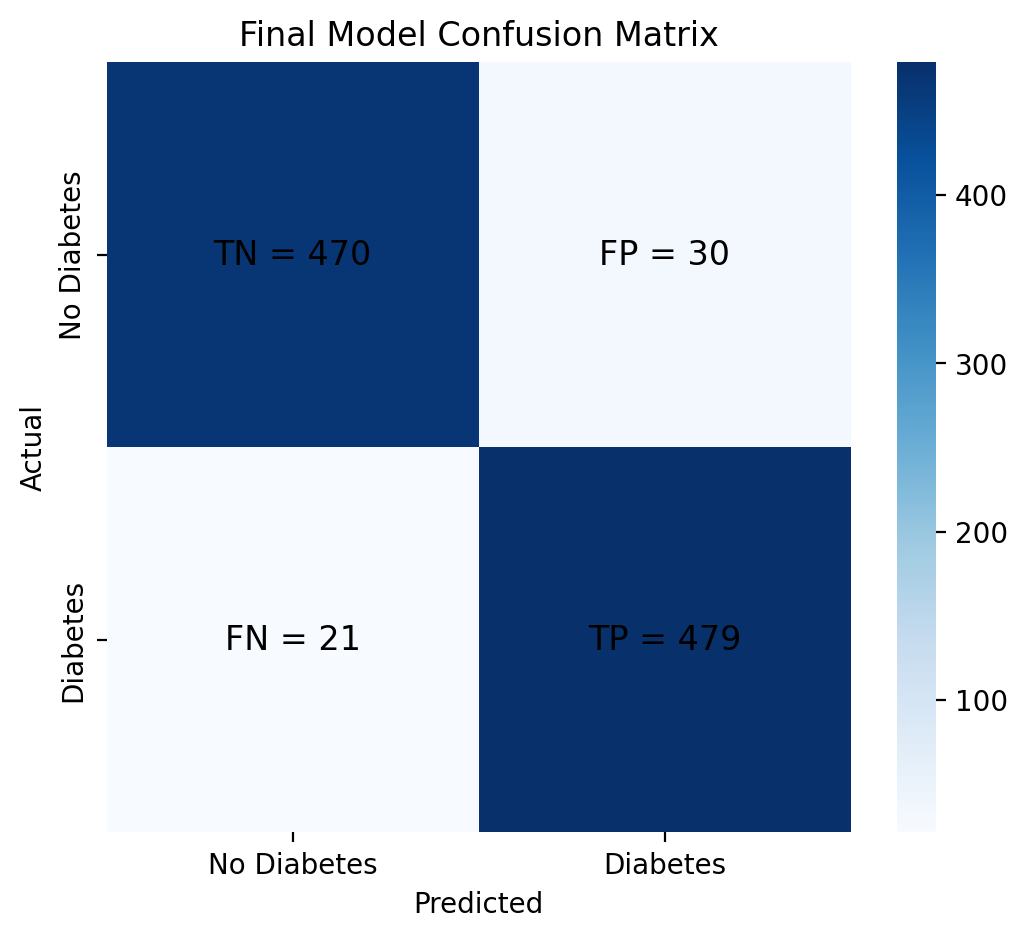

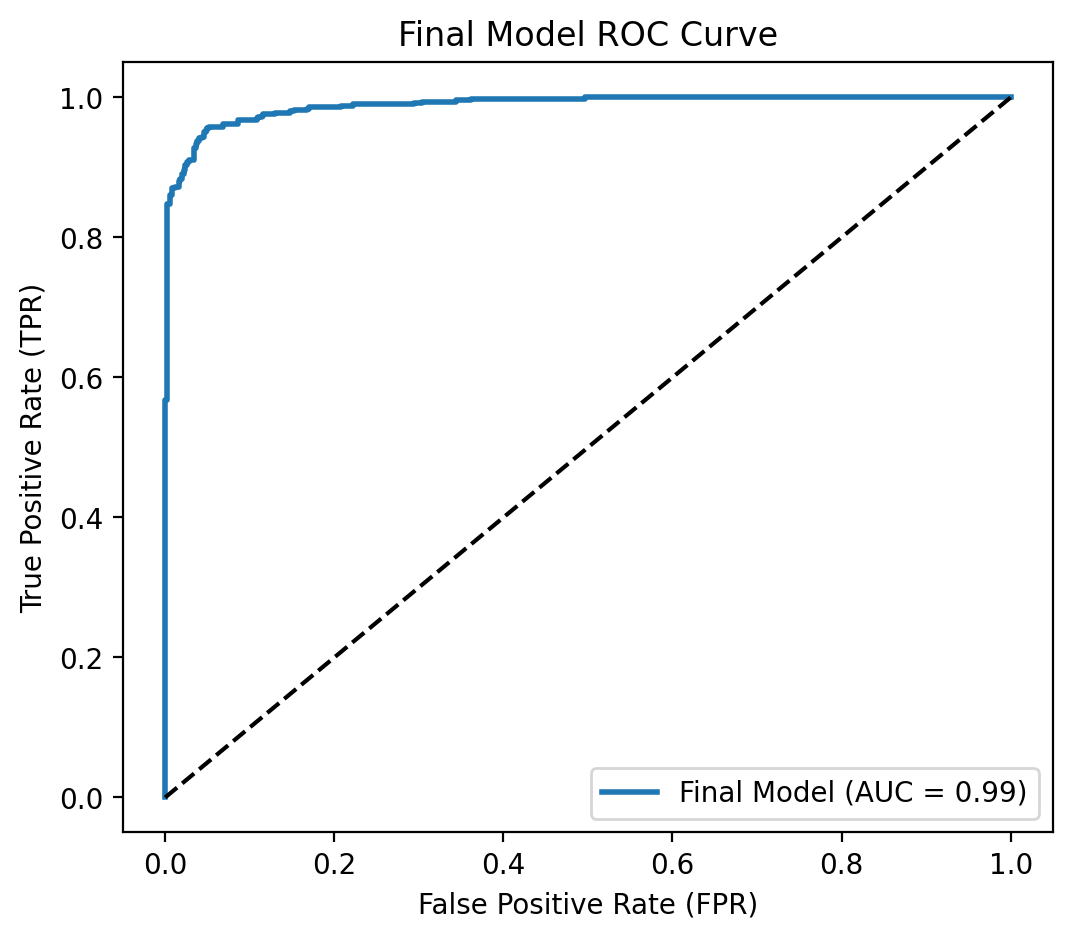

In [30]:
# Cell 9: Evaluation (Enhanced)
final_model.eval()
with torch.no_grad():
    outputs = final_model(torch.FloatTensor(X_normalized_sel.values))
    y_pred = (outputs > 0.5).float().numpy()
    y_scores = outputs.numpy()  # For ROC curve
    
    # Calculate metrics
    final_acc = accuracy_score(y_res, y_pred)
    final_cm = confusion_matrix(y_res, y_pred)
    TN, FP, FN, TP = final_cm.ravel()
    
    # Additional metrics
    final_precision = precision_score(y_res, y_pred)
    final_recall = recall_score(y_res, y_pred)  # TPR
    final_f1 = f1_score(y_res, y_pred)
    final_tpr = final_recall
    final_fpr = FP / (FP + TN)
    final_error_rate = (FP + FN) / (TP + TN + FP + FN)
    final_auc = roc_auc_score(y_res, y_scores)
    
    # Classification report
    final_report = classification_report(y_res, y_pred, target_names=['No Diabetes', 'Diabetes'])
    
    # ROC curve data
    fpr_roc, tpr_roc, _ = roc_curve(y_res, y_scores)

# Print final performance
print("\n" + "="*80)
print("NEURO-FUZZY SYSTEM (NFS) PERFORMANCE".center(80))
print("="*80)

# Tabulated metrics
metrics_table = [
    ["Accuracy", f"{final_acc:.4f}"],
    ["Precision", f"{final_precision:.4f}"],
    ["Recall (TPR)", f"{final_recall:.4f}"],
    ["F1-Score", f"{final_f1:.4f}"],
    ["False Positive Rate (FPR)", f"{final_fpr:.4f}"],
    ["Error Rate", f"{final_error_rate:.4f}"],
    ["AUC-ROC", f"{final_auc:.4f}"]
]
print("\nKey Metrics:")
print(tabulate(metrics_table, headers=["Metric", "Value"], tablefmt="grid"))

# Plot Confusion Matrix with annotations
plt.figure(figsize=(6, 5))
sns.heatmap(final_cm, annot=False, fmt='d', cmap='Blues',
            xticklabels=['No Diabetes', 'Diabetes'],
            yticklabels=['No Diabetes', 'Diabetes'])
plt.text(0.5, 0.5, f'TN = {TN}', ha='center', va='center', color='black', fontsize=12)
plt.text(1.5, 0.5, f'FP = {FP}', ha='center', va='center', color='black', fontsize=12)
plt.text(0.5, 1.5, f'FN = {FN}', ha='center', va='center', color='black', fontsize=12)
plt.text(1.5, 1.5, f'TP = {TP}', ha='center', va='center', color='black', fontsize=12)
plt.title('Final Model Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Plot ROC Curve
plt.figure(figsize=(6, 5))
plt.plot(fpr_roc, tpr_roc, label=f'Final Model (AUC = {final_auc:.2f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Final Model ROC Curve')
plt.legend(loc='lower right')
plt.show()

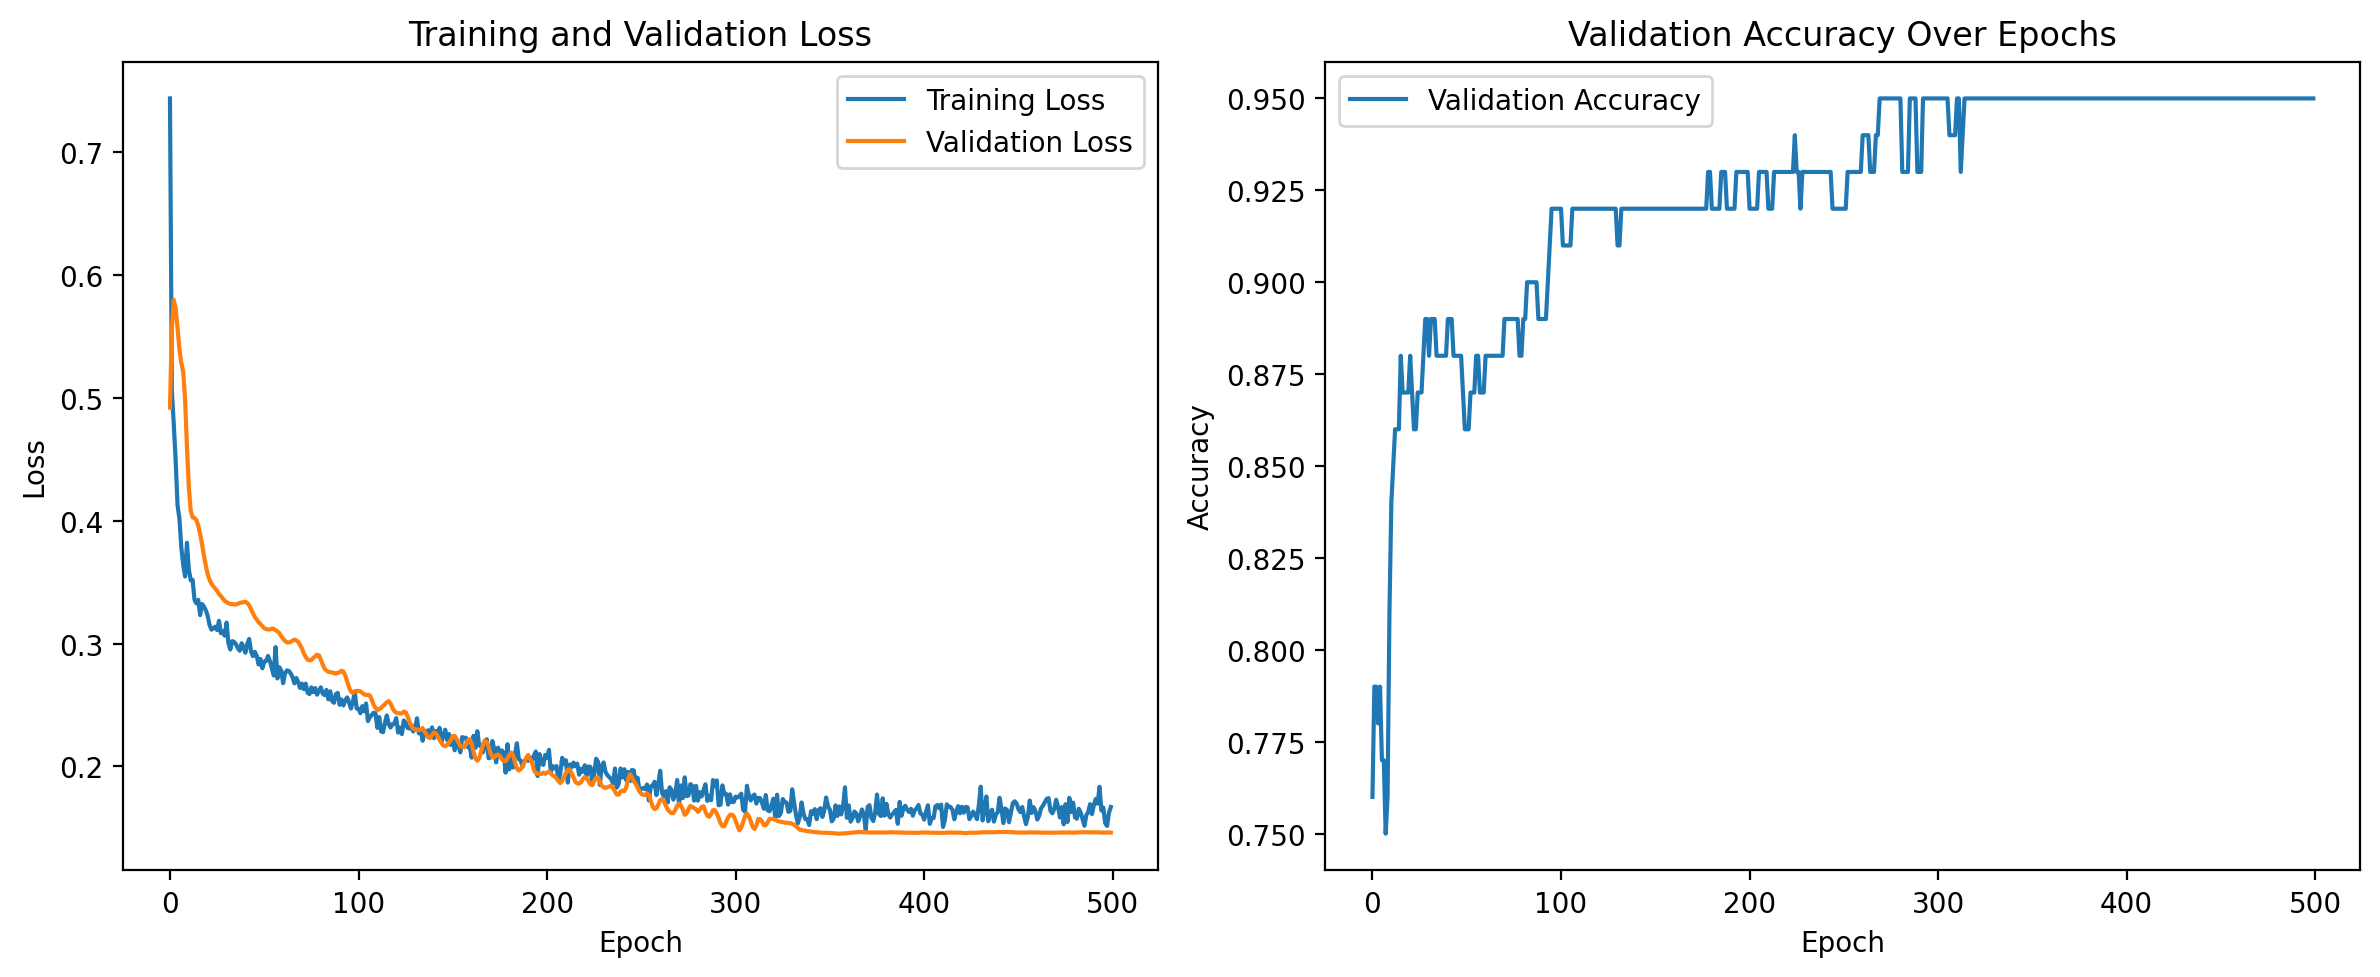

In [31]:
# Cell 11: Training History Visualization
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(final_history['train_loss'], label='Training Loss')
plt.plot(final_history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(final_history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Validation Accuracy Over Epochs')
plt.tight_layout()
plt.show()

In [32]:
# Cell 12: Rule Extraction
extract_and_print_rules(final_model, selected_features, feature_ranges)


================= CLINICAL INTERPRETATION (SELECTED FEATURES) ==================

** Rule 1 **
IF
  • Insulin         is Low    (84.6±211.5) [Weight: 0.20]
  • Glucose         is Low    (19.9±49.8) [Weight: 0.40]
  • BMI             is Low    (6.7±16.8) [Weight: 0.25]
  • Age             is Low    (27.0±15.0) [Weight: 0.10]
  • DiabetesPedigreeFunction is Low    (0.3±0.6) [Weight: 0.05]

THEN → LOW diabetes risk (Healthy) ✓✓✓
  Composite Risk Score: 0.100/1.0

** Rule 2 **
IF
  • Insulin         is Medium (107.9±211.5) [Weight: 0.20]
  • Glucose         is Low    (25.4±49.8) [Weight: 0.40]
  • BMI             is Low    (8.6±16.8) [Weight: 0.25]
  • Age             is Low    (28.7±15.0) [Weight: 0.10]
  • DiabetesPedigreeFunction is Low    (0.4±0.6) [Weight: 0.05]

THEN → LOW diabetes risk (Healthy) ✓✓✓
  Composite Risk Score: 0.128/1.0

** Rule 3 **
IF
  • Insulin         is Medium (131.3±211.5) [Weight: 0.20]
  • Glucose         is Low    (30.9±49.8) [Weight: 0.40]
  • BMI           

In [33]:
X_normalized

Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0       0.631479  0.707532       0.146610       0.874630  0.201161  0.083786   
1      -0.890157 -1.331568      -0.157035       0.501654 -0.560083 -0.974250   
2       1.240134  1.840365      -0.258251      -1.301067  0.201161 -1.473038   
3      -0.890157 -1.202101      -0.157035       0.128677 -0.656659 -0.747528   
4      -1.194485  0.351498      -1.472834       0.874630  0.184118  1.519692   
..           ...       ...            ...            ...       ...       ...   
995     0.327152  1.239056      -0.258251      -1.301067  0.201161 -0.172243   
996    -0.890157 -0.296374      -0.005213       0.563816  0.172851  0.007456   
997    -0.281503  1.668880       0.804509       0.439491  0.080405  0.109179   
998     1.240134 -0.469859       0.602079       0.688142  0.273433  0.170409   
999     0.631479  0.505228      -0.055820       1.123281  0.201161  0.721479   

     DiabetesPedigreeFunction       Age  
0                    0.403313  1.422889  
1                   -0.432028 -0.256818  
2                    0.539510 -0.168413  
3                   -0.988922 -1.140875  
4                    5.430491 -0.080007  
..                        ...       ...  
995                 -0.787367  0.450427  
996                 -0.888069 -0.433630  
997                  1.483900  1.334483  
998                 -0.634004  0.096804  
999                  0.639780  0.715644  

[1000 rows x 8 columns]

In [34]:
feature_ranges = {col: (X_normalized[col].min(), X_normalized[col].max()) for col in selected_features}
feature_ranges

{'Insulin': (-1.5656073507941304, 7.887455948618908),
 'Glucose': (-2.658601107057649, 2.3582313605426157),
 'BMI': (-2.2438930083459154, 5.147243948066296),
 'Age': (-1.1408745866692716, 4.16346289493912),
 'DiabetesPedigreeFunction': (-1.258288877892533, 5.830002112072932)}